<h1 style="color:blue"> Bayesian Statistics and Probabilistic Programming</h1>

<h1 style="color:blue"> Spring 2023 - Homework 01</h1>

<h3 style="color:blue">2023-03-27</h3>

## Team names

Sergi Bech Sala. mail: sbechsal7@alumnes.ub.edu

Sara Bardají Serra. mail: sbardase7@alumnes.ub.edu

David Rosado Rodríguez. mail: drosadro11@alumnes.ub.edu

***
###### LaTeX macros
$\def\prob{P}$
$\def\argmax{\operatorname{arg\,max}}$
$\def\argmin{\operatorname{arg\,min}}$
$\def\borel{\operatorname{Borel}}$
$\def\cE{\cal E}$
$\def\cP{\cal P}$
$\def\R{\mathbb{R}}$ 
$\def\N{\mathbb{N}}$
$\def\Z{\mathbb{Z}}$
$\def\Ee{\operatorname{E}}$
$\def\va{\text{v.a.}}$
$\def\var{\operatorname{var}}$
$\def\cov{\operatorname{cov}}$
$\def\cor{\operatorname{cor}}$
$\def\binomdist{\operatorname{Binom}}$
$\def\berndist{\operatorname{Ber}}$
$\def\betabinomdist{\operatorname{Beta-Binom}}$
$\def\betadist{\operatorname{Beta}}$
$\def\expdist{\operatorname{Exponential}}$
$\def\gammadist{\operatorname{Gamma}}$
$\def\hyperdist{\operatorname{Hypergeom}}$
$\def\hypergeomdist{\operatorname{Hypergeom}}$
$\DeclareMathOperator{\multinomialdist}{Multinomial}$
$\DeclareMathOperator{\multinomdist}{Multinom}$
$\def\poissondist{\operatorname{Poisson}}$
$\def\geomdist{\operatorname{Geom}}$
$\def\normaldist{\operatorname{N}}$
$\def\unifdist{\operatorname{Unif}}$
$\DeclareMathOperator{\indica}{\mathbb{1}}$
$\def\CondTo{\mathbin{|\mskip0.5mu}}$
***

<h1 style="color:blue">Instructions</h1>

### Submissions: 

By **groups** of _about_ three students (meaning: two is OK, four is not advisable but possible. Individual homeworks 
will also be accepted but collaborative work is preferable). 

Please send me an **email** with the team members names as soon as you have formed it.

Only **one copy** of each group's work must be uploaded (by any member).

**Full names** and **email address** of all team members must appear in the header. 

### Format: 

A Jupyter or R Markdown **notebook,** with a **header** clearly stating the names of all contributors. 

### Documentation: 

Comments **in code cells** (e.g., meaning of variables, parameters, purpose of functions) are necessary but not sufficient.

You are expected to give full explanations of steps taken in your solution (in **Markdown cells**), as well as discussion of results and their meaning.

Do not be afraid of being too verbose or too elementary, explain as if to someone learning.

### External sources

Getting _inspiration_ from any book, document, blog, web page, even mimicking solutions given in there, is **allowed and encouraged,** provided you give a **proper reference,** understand every such material, and explain it in you own words, even more exhaustively.

Do not **copy/paste literally large chunks of code** I will detect it, believe me, even missing source reference. Bleak consequences.

### Deadline:

Completed assignments are due on Monday, April 17. They are to be uploaded to the Virtual Campus.

<h1 style="color:blue">01 - Stan version of a conjugate prior problem</h1>

<h2 style="color:blue">Modelling Earthquake Waiting Times</h2>

Consider the problem in `Exponential.02.Earthquake` (notebook in 2023-03-27 folder), where the goal is to study earthquake waiting times.

Likelihood is modelled as an $\expdist(\lambda)$ and $\lambda$ is given a conjugate prior, $\lambda\sim\gammadist(\alpha,\beta)$.

In the `Exponential.02.Earthquake` notebook some simulations are performed for:

01. Prior pdf for $\lambda$.
02. Prior predictive pdf for the waiting time.
03. Posterior pdf for $\lambda$.
04. Posterior predictive for new waiting time.

using known theoretical (analytical) descriptions of these distributions.

Your task is to redo these simulations using Stan (avoiding conjugate prior formulas), then compare your results to the analytical ones. 

Use this comparison to tune up adjustable parameters in Stan sampling, such as chain length. 

## SOLUTION EXERCISE 1

First, let us install rstan dependencies.

In [1]:
#install.packages("rstan", dependencies=TRUE,repos= "https://cloud.r-project.org")
require(rstan)


The downloaded binary packages are in
	/var/folders/nc/wbbw2w1x72dg89nnx4p_1xwr0000gn/T//RtmpWIwJco/downloaded_packages


Loading required package: rstan

Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.21.8, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)



In [2]:
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

We are going to redo the simulations performed in the `Exponential.02.Earthquake` notebook using Stan. Let us start by initializing some variables. We know the following:

+ $ \lambda\sim\operatorname{Gamma}(\alpha,\beta)$ with $\alpha=1$ and $\beta=30$.

+ Significant earthquakes: Jan 4, Jan 20, Jan 28, May 22, July 21, July 25, Aug 17, Sept 16, Dec 30. Thus, our data vector is (16, 8, 114, 60, 4, 23, 30, 105).

+ The posterior pdf for $\lambda$ is a $\operatorname{Gamma}$ with parameters $\alpha'$ and $\beta'$ where $\alpha'=\alpha+n$ and $\beta'=\beta+n\,\overline{y}$, with  $n$ being the number of observations and $\overline{y}$ being the mean of the observations.



In [3]:
# Initializations of variables

prior.a<- 1 # prior alpha
prior.b<- 30 # prior beta

obs <- c(16, 8, 114, 60, 4, 23, 30, 105) # data observation vector

n <- length(obs)
ybar<-mean(obs)
nybar<-sum(obs)

posterior.a<-prior.a+n # posterior alpha
posterior.b<-prior.b+nybar # posterior beta

#### 1.  Prior pdf for $\lambda$ and prior predictive pdf for the waiting time.

Let us define the Bayesian model in the Stan programming language. The only inputs that our model receives are the `data` block, in which we declare two parameters, *prior_a* and *prior_b*, the hyperparameters for a gamma prior distribution on the model parameter theta. The lower=0 constraint on both *prior_a* and *prior_b* ensures that the hyperparameters are positive. The `parameters` block declares the model parameters that need to be estimated from the data. In this case, there is only one parameter *theta*, which is the rate parameter of an exponential distribution. The `model` block specifies the likelihood function and the prior distribution on the parameters. Here, *theta* is assumed to have a gamma prior distribution with hyperparameters *prior_a* and *prior_b*. Finally, the `generated quantities` block specifies any additional quantities that we want to compute based on the posterior distribution of the parameters. In this case, we generate a random variable *y_pred* from an exponential distribution with parameter *theta*.

In [4]:
stanmodelcode <- "
data {
        real<lower=0> prior_a;
        real<lower=0> prior_b;
    }

parameters {
        real<lower=0.00001> theta;
    }

model {
        theta ~ gamma(prior_a,prior_b);
    }

generated quantities {
        real y_pred;
        y_pred = exponential_rng(theta);
    }
    "  

We are ready to compile the code.

In [5]:
# Translate model to C++ and compile to DSO:
stanDso <- stan_model(model_code=stanmodelcode) 

Now, we create a list of the inputs parameters to perform the sampling for the prior functions.

In [6]:
dat <- list(prior_a=prior.a, prior_b=prior.b)

In [7]:
fit <- sampling(stanDso, data = dat, iter = 10000, chains = 1, warmup = 5000, thin = 1)


SAMPLING FOR MODEL '63803584987616e4dabe4f943a08d52e' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1.5e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.020723 seconds (Warm-up)
Chain 1:                0.014902 second

Extract the values that model both prior $\lambda$ and the prior predictive for the waiting time.

In [8]:
pr_theta <- extract(fit, 'theta')
pr_theta <- unlist(pr_theta, use.names=FALSE) # prior lambda
pry_pred <- extract(fit, 'y_pred')
pry_pred <- unlist(pry_pred, use.names=FALSE) # prior predictive expecting time

Finally, we can plot the results to compare the simulated prior predictive and simulated prior parameter to the analytical ones. Before, notice that the predictive distribution is a Pareto II (Lomax), hence, we need to import *actuar* in order to plot the analytical predictive distributions.

In [9]:
#install.packages("actuar", dependencies=TRUE,repos= "https://cloud.r-project.org")
require(actuar) # Required for pareto distribution


The downloaded binary packages are in
	/var/folders/nc/wbbw2w1x72dg89nnx4p_1xwr0000gn/T//RtmpWIwJco/downloaded_packages


Loading required package: actuar


Attaching package: ‘actuar’


The following objects are masked from ‘package:stats’:

    sd, var


The following object is masked from ‘package:grDevices’:

    cm




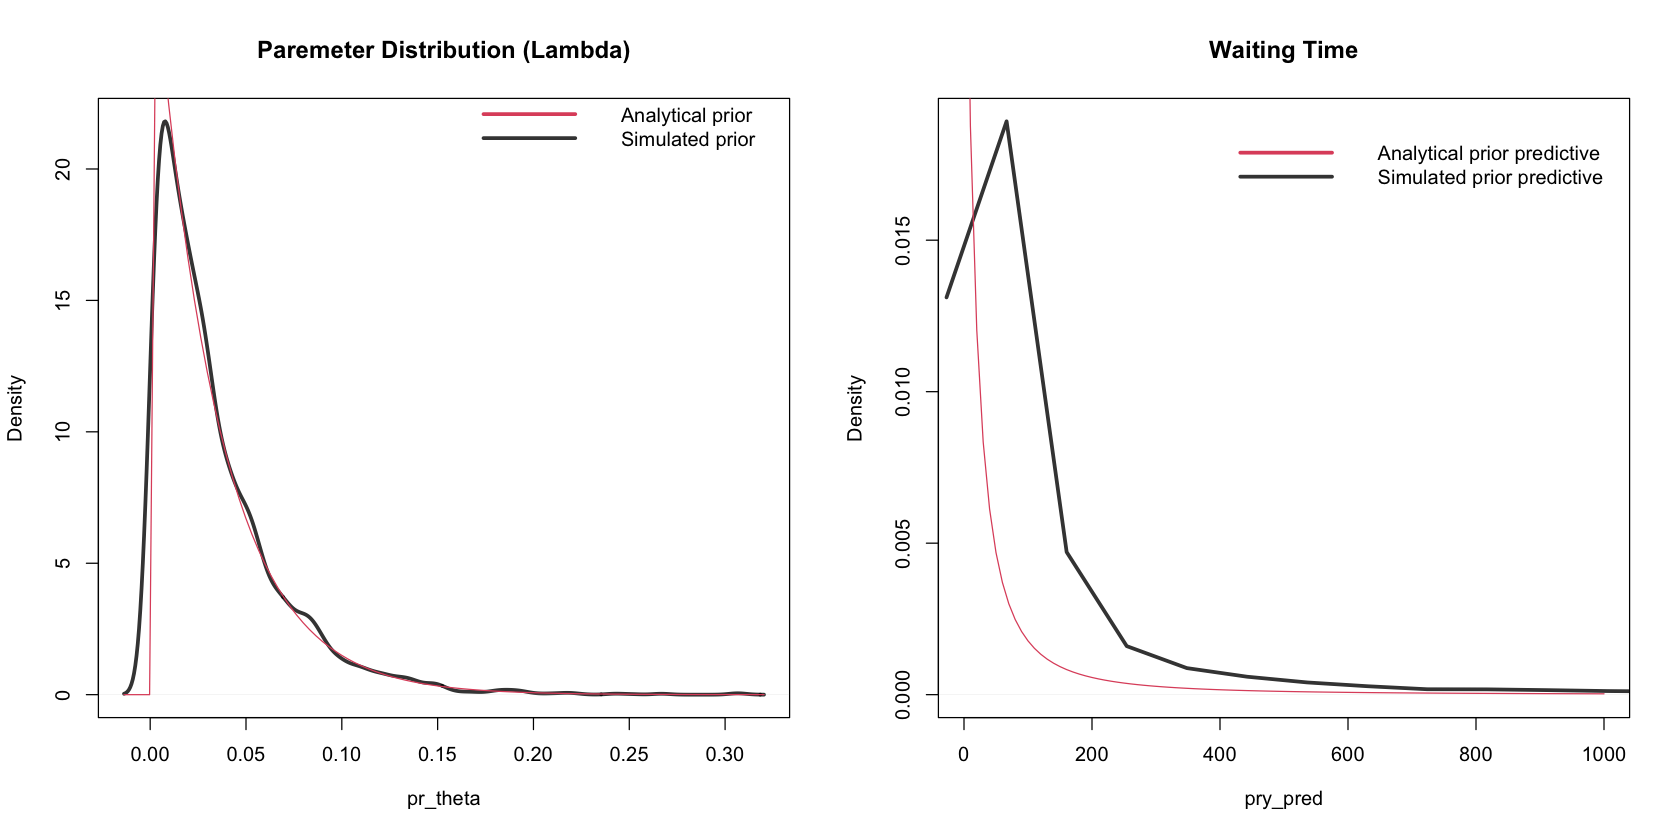

In [10]:
# Plot
options(repr.plot.width=14,repr.plot.height=7)
old.par<- par(mfrow=c(1,2))

# Simulated prior parameter
plot(density(pr_theta),
     xlab=expression(pr_theta), col=grey(0, 0.8),lwd=3,
     main="Paremeter Distribution (Lambda)")
# Analytical prior parameter
curve(dgamma(x, prior.a, prior.b), 
      add=TRUE, col=2)
legend(x=0.15,y=23,legend=c("Analytical prior", "Simulated prior"), 
           col=c(2, grey(0, 0.8)), lty=c(1,1), bty="n",lwd=3)
# Simulated prior predictive
plot(density(pry_pred),xlim=c(0,1000),
     xlab=expression(pry_pred), col=grey(0, 0.8),lwd=3,
     main="Waiting Time")
# Analytical prior predictive
curve(dpareto(x, prior.a, prior.b), 
      add=TRUE, col=2)
legend(x=360,y=0.01868,legend=c("Analytical prior predictive", "Simulated prior predictive"), 
           col=c(2, grey(0, 0.8)), lty=c(1,1), bty="n",lwd=3)
par(old.par)
     


Notice that simulations are similar to the analytical approach. The first picture, shows a really similar behaviour between the analytical prior for $\lambda$ and the analytical one, meanwhile, in the second one, we can observe that, at the beginning, the simulated prior predictive pdf for the waiting time is slighlty different to the analytical one, but immediately mimics its behavior. 

#### 3. Posterior pdf for  $\lambda$ and posterior predictive for new waiting time.
We need to create another Bayesian model in the Stan programming language. We need to take into account the observations to perform simulations on the posterior pdf. Thus, $y[n]$ will receive the observations and include them into the simulations to generate posterior distributions.

In [11]:
stanmodelcode <- "
data {
        real<lower=0> prior_a;
        real<lower=0> prior_b;
        int n;
        real y[n];
    }

parameters {
        real<lower=0.00001> theta;
    }

model {
        theta ~ gamma(prior_a,prior_b);
        y ~ exponential(theta);
    }

generated quantities {
        real y_pred;
        y_pred = exponential_rng(theta);
    }
    "

We are ready to compile the code.

In [12]:
# Translate model to C++ and compile to DSO:
stanDso <- stan_model(model_code=stanmodelcode) 

Now, we create a list of the inputs parameters to perform the sampling for the posterior functions.

In [13]:
dat <- list(n = n, y = obs, prior_a=prior.a, prior_b=prior.b)

In [14]:
fit <- sampling(stanDso, data = dat, iter = 10000, chains = 1, warmup = 5000, thin = 1)


SAMPLING FOR MODEL '282d38368886cc2462d7487af4794651' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 5e-06 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.012851 seconds (Warm-up)
Chain 1:                0.012859 seconds 

Extract the values that model both posterior pdf for $\lambda$ and the posterior predictive for new waiting time.

In [15]:
pos_theta <- extract(fit, 'theta')
pos_theta <- unlist(pos_theta, use.names=FALSE) # posterior lambda
posy_pred <- extract(fit, 'y_pred')
posy_pred <- unlist(posy_pred, use.names=FALSE) # posterior predictive expecting time

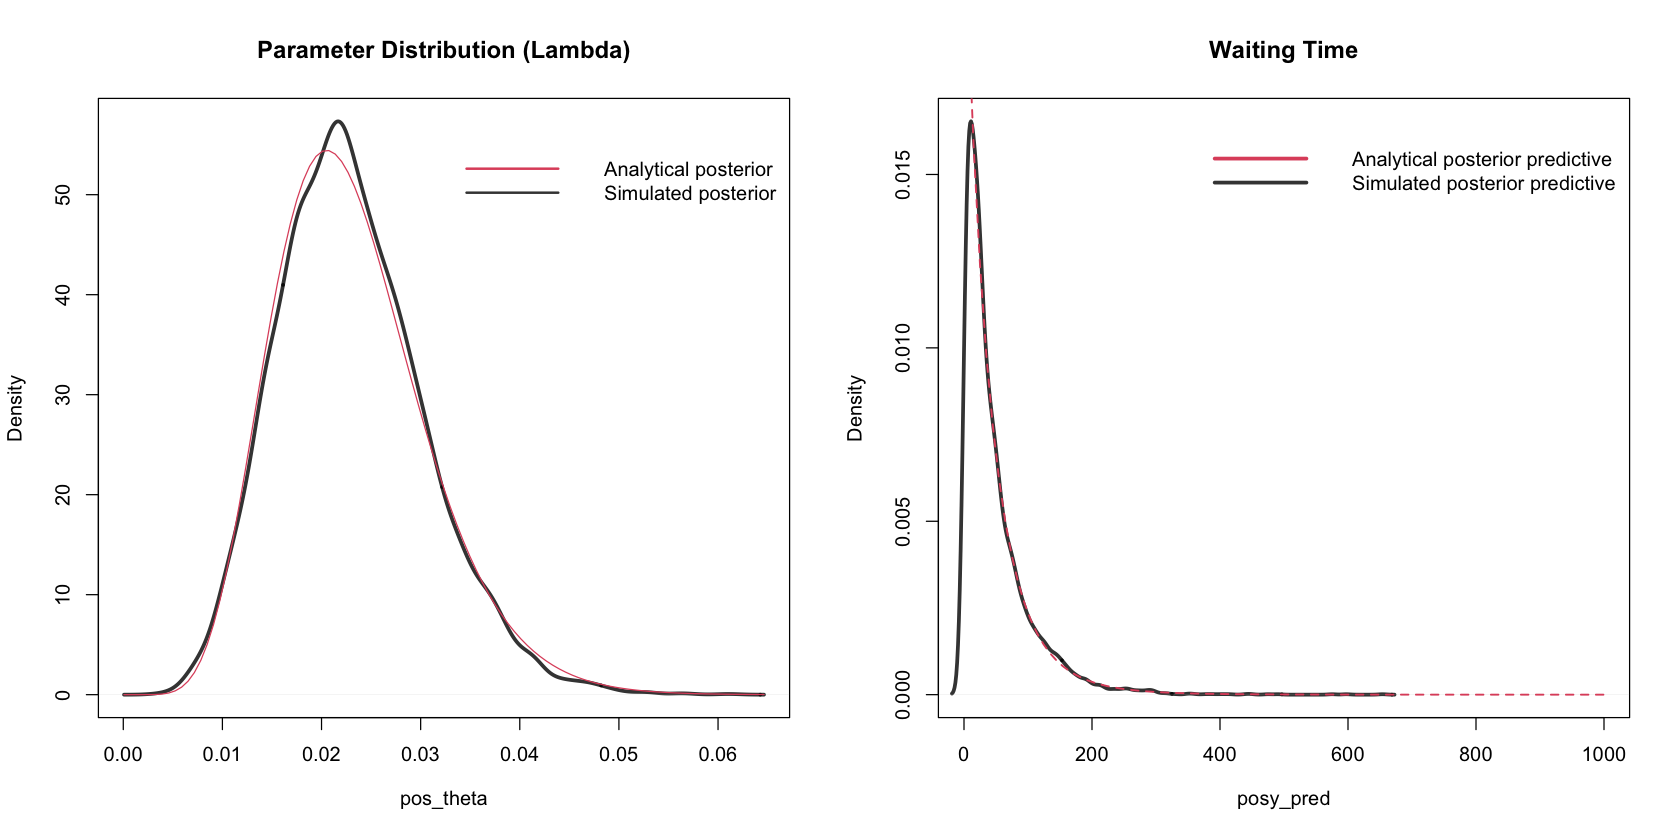

In [16]:
# Plot
options(repr.plot.width=14,repr.plot.height=7)
old.par<- par(mfrow=c(1,2))

# Simulated posterior parameter
plot(density(pos_theta),
     xlab=expression(pos_theta), col=grey(0, 0.8),lwd=3,
     main="Parameter Distribution (Lambda)")
# Analytical posterior parameter
curve(dgamma(x, posterior.a, posterior.b), 
      add=TRUE, col=2)
legend(x=0.03,y=55,legend=c("Analytical posterior", "Simulated posterior"), 
           col=c(2, grey(0, 0.8)), lty=c(1,1), bty="n",lwd=2)
# Simulated posterior predictive
plot(density(posy_pred),xlim=c(0,1000),
     xlab=expression(posy_pred), col=grey(0, 0.8),lwd=3,
     main="Waiting Time")
# Analytical posterior predictive
curve(dpareto(x, posterior.a, posterior.b), 
      add=TRUE, col=2, lwd=1.5, lty=2,5)
legend(x=320,y=0.01615,legend=c("Analytical posterior predictive", "Simulated posterior predictive"), 
           col=c(2, grey(0, 0.8)), lty=c(1,1), bty="n",lwd=3)
par(old.par)
     


As in the prior, notice that simulations are similar to the analytical approach. Let us try to improve our result!

#### Tuning parameters

 Let us tune up adjustable parameters in Stan sampling, such as chain length, in order to improve the results.

**Parameter explanation**

+ **iter**: This is the total number of iterations that the MCMC algorithm will run for each chain. In other words, it's the total number of samples that will be drawn from the posterior distribution.

+ **chains**: This is the number of independent Markov chains that will be run. It's generally a good idea to use more than one chain to ensure that the MCMC algorithm has converged to the true posterior distribution.

+ **warmup**: This is the number of iterations that will be used for the warm-up phase of the MCMC algorithm. During the warm-up phase, the algorithm will adjust its proposal distribution to better match the target distribution. The warm-up samples are not included in the final output.

+ **thin**: This is the thinning factor, which determines how many samples are kept from each chain. For example, if thin = 2, every other sample will be kept, effectively reducing the size of the output by half. Thinning can be useful for reducing the autocorrelation between samples and reducing the size of the output. However, it can also reduce the effective sample size and increase the uncertainty of the estimates.

In [17]:
fit <- sampling(stanDso, data = dat, iter = 10000, chains = 4, warmup = 5000, thin = 2)

In [18]:
pos_theta <- extract(fit, 'theta')
pos_theta <- unlist(pos_theta, use.names=FALSE)
posy_pred <- extract(fit, 'y_pred')
posy_pred <- unlist(posy_pred, use.names=FALSE)

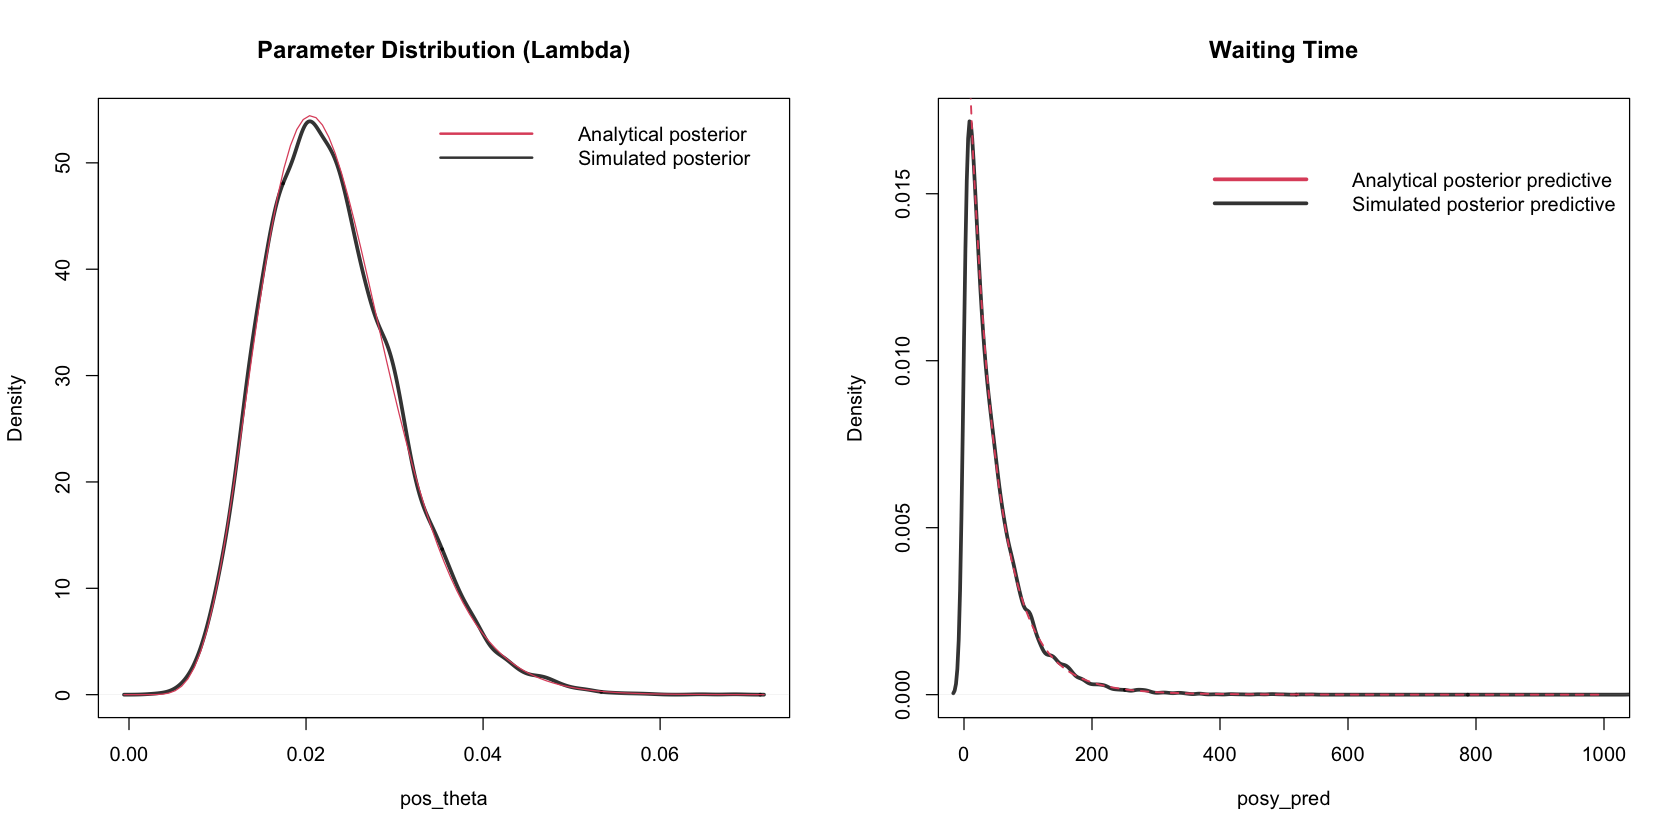

In [19]:
# Plot
options(repr.plot.width=14,repr.plot.height=7)
old.par<- par(mfrow=c(1,2))

# Simulated posterior parameter
plot(density(pos_theta),
     xlab=expression(pos_theta), col=grey(0, 0.8),lwd=3,
     main="Parameter Distribution (Lambda)")
# Analytical posterior parameter
curve(dgamma(x, posterior.a, posterior.b), 
      add=TRUE, col=2)
legend(x=0.03,y=55,legend=c("Analytical posterior", "Simulated posterior"), 
           col=c(2, grey(0, 0.8)), lty=c(1,1), bty="n",lwd=2)
# Simulated posterior predictive
plot(density(posy_pred),xlim=c(0,1000),
     xlab=expression(posy_pred), col=grey(0, 0.8),lwd=3,
     main="Waiting Time")
# Analytical posterior predictive
curve(dpareto(x, posterior.a, posterior.b), 
      add=TRUE, col=2, lwd=1.5, lty=2,5)
legend(x=320,y=0.01615,legend=c("Analytical posterior predictive", "Simulated posterior predictive"), 
           col=c(2, grey(0, 0.8)), lty=c(1,1), bty="n",lwd=3)
par(old.par)
      


Notice that adding more chains to the sampling, we can prevent a possible bias due to starting point and be able to perform convergence diagnostics. Moreover, we have increased the thin parameter to 2, to kept every every other sample. With this hyperparameter tuning, the simulated posterior pdf for $\lambda$ reach a higher similar behaviour to the analytical one, as well as, the posterior predictive for new waiting time and the analytical one.

<h1 style="color:blue">02 - A more elaborate mixture prior for the spinning coin</h1>

(continued from Diaconis experiment)

On reflection, it was decided that tails had come up more often than heads in the past; further some coins seemed likely to be symmetric. 

Thus, a final approximation to the prior was taken as:

$$
    0.50\cdot\betadist(10,20) + 0.20\cdot\betadist(15,15) + 0.30\cdot\betadist(20,10).
$$

Same observed data as in the previous model.

In [3]:
# Number of trials
n<-10
# Observed x
x.obs<-3

Perform a complete Bayesian analysis of this model, in close parallel to the first example.

(1) Using the theoretical formulas (prior predictive pmf, posterior pdf, posterior predictive pmf)

(2) Using independent random numbers (`rbeta()` functions, etc.)

(3) JAGS version

(4)$ {}^{\star}$ Stan version. 

>$ (\star)$ Hint: this one **is difficult** due to intrinsic limitations in Stan:   
Stan does not allow integer parameters thus the JAGS code cannot be translated literally.  

>As a matter of fact even a Stan version of the two-components prior mixture in `Mixture.priors.02.ipynb` 
is tricky.   
There are several possible workarounds; try to find one but do not despair if you fail to develop a workable version.

## SOLUTION EXERCISE 2

### The model

The problem at hand involves a combination of three Beta distributions, which forms a Beta-Bernoulli model. The goal is to gain insight into this distribution by studying a series of independent experiments, which can be represented as a Binomial distribution with size $n$ and probability determined by the Beta-Bernoulli distribution. The likelihood is expressed as:

$$x∼\binomdist(n,\theta)\hspace{0.3cm}\text{where}\hspace{0.3cm}\theta∼0.50⋅\betadist(10,20)+0.20⋅\betadist(15,15)+0.30⋅\betadist(20,10)$$

Before continue, let us plot the PDF of the prior distribution, the mixture of three Beta.

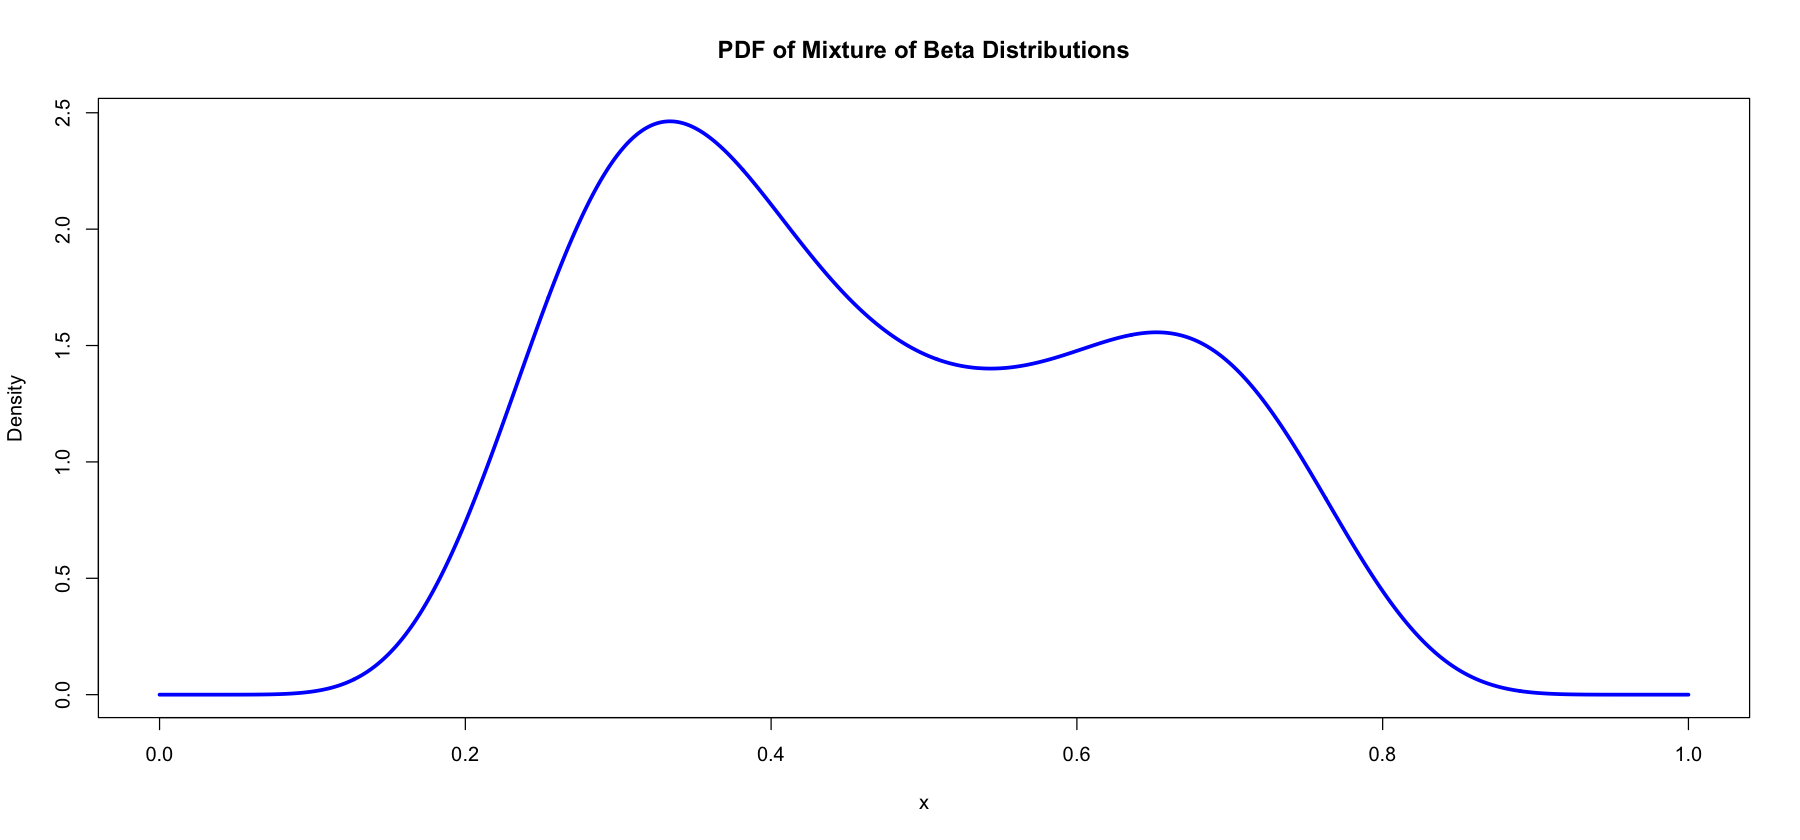

In [24]:
# Define the weights and parameters for the beta distributions
w_prior <- c(0.5, 0.2, 0.3)
a_prior <- c(10, 15, 20)
b_prior <- c(20, 15, 10)

# Define the range of x values to plot
x <- seq(0, 1, length.out = 1000)

# Compute the PDF  of the mixture distribution
pdf_prior <- w_prior[1] * dbeta(x, a_prior[1], b_prior[1]) +
             w_prior[2] * dbeta(x, a_prior[2], b_prior[2]) +
             w_prior[3] * dbeta(x, a_prior[3], b_prior[3])

# Plot the PDF 
plot(x, pdf_prior, type = "l", lwd = 3, col = "blue",
     main = "PDF of Mixture of Beta Distributions",
     xlab = "x", ylab = "Density")


###  1.Bayesian Analysis using the theoretical formulas
+ prior predictive pmf
+ posterior pdf
+ posterior predictive pmf

Our prior pdf can be defined as
 
$$ P(\theta) = \omega_1 P_1(\theta) + \omega_2 P_3(\theta) + \omega_3 P_3(\theta).$$
 
Recall that we define the **prior predictive distribution** as the distribution of possible unobserved values conditional on the observed values. Hence, the prior predictive distribution can be obtained by integrating the product of the Bernoulli likelihood, $P(x|\theta),$ and the Beta prior over the probability parameter $\theta$. The prior predictive distribution is given by

$$f(x) = \omega_1 f_1(x) + \omega_2 f_2(x) + \omega_3 f_3(x). $$

where 

$$f_i(x) = \int P(x|\theta)P_i(\theta)d\theta\hspace{0.2cm} i=1,2,3. $$

Notice that the Bernoulli likelohood is given by

$$P(x|\theta) = {n \choose x}\theta^x(1-\theta)^{n-x}.$$

Then, the prior predictive distribution is a mixture of three partial prior predictive pdf's, with the same coefficients $\omega_1,\omega_2,\omega_3$. Actually, it is not difficult to see, and in fact, we will show it in a moment, that these partial predictive pdf's are Beta's.
 
Now, we are ready to compute the **posterior pdf**. First, let us define the joint pdf as

$$P(\theta,x)=\omega_1 P_1(\theta,x) + \omega_2 P_2(\theta,x) + \omega_3 P_3(\theta,x). $$

Using Baye's formula, we can obtain the posterior pdf:

$$ P(\theta|x) = \frac{P(\theta,x)}{f(x)} = \frac{\omega_1 P_1(\theta,x) + \omega_2 P_2(\theta,x) + \omega_3 P_3(\theta,x)}{\omega_1 f_1(x) + \omega_2 f_2(x) + \omega_3 f_3(x)} = \frac{\omega_1 f_1(x)P_1(\theta|x)+\omega_2 f_2(x)P_2(\theta|x)+\omega_3 f_3(x)P_3(\theta|x)}{\omega_1 f_1(x) + \omega_2 f_2(x) + \omega_3 f_3(x)}.$$

where 

$$ P_i(\theta|x)=\frac{P_i(\theta,x)}{f_i(x)}.$$

Hence, the posterior pdf is

$$ P(\theta|x) = \hat{w_1}P_1(\theta|x)+\hat{w_2}P_2(\theta|x)+\hat{w_2}P_2(\theta|x).$$

where  $ \hat{w_i} = \lambda \omega_i f_i(x)$ weighted so that three constants keep adding to 1. Thus, it is enough to obtain $f_i(x).$

$$f_i(x) = \int_{0}^{1} P(x|\theta)P_i(\theta)d\theta= \int_{0}^{1}\left({n \choose x}\theta^x(1-\theta)^{n-x} \right)\left(\frac{1}{B(\alpha,\beta)}\theta^{\alpha-1}(1-\theta)^{\beta-1}\right)d\theta ={n \choose x}\frac{1}{B(\alpha,\beta)}\int_{0}^{1}\theta^{x+\alpha-1}(1-\theta)^{n+\beta-x-1}d\theta = $$

$$={n \choose x}\frac{B(x+\alpha,n+\beta-x)}{B(\alpha,\beta)}\int_{0}^{1}\frac{\theta^{x+\alpha-1}(1-\theta)^{n+\beta-x-1}}{B(x+\alpha,n+\beta-x)}d\theta ={n \choose x}\frac{B(x+\alpha,n+\beta-x)}{B(\alpha,\beta)}. $$

Finally,

$$ P_i(\theta|x)=\frac{P_i(\theta,x)}{f_i(x)}=\frac{B(\alpha,\beta)}{{n \choose x}B(x+\alpha,n+\beta-x)}\frac{{n \choose x}\theta^{x+\alpha-1}(1-\theta)^{n+\beta-x-1}}{B(\alpha,\beta)} = P_i(x+\alpha,n+\beta-x).$$


Before continue, let us plot the PDF  of the posterior distribution. The code is exactly the same as before, but we need to update the parameters to the new ones and compute the $f_i$ to re-weight the previous weights.

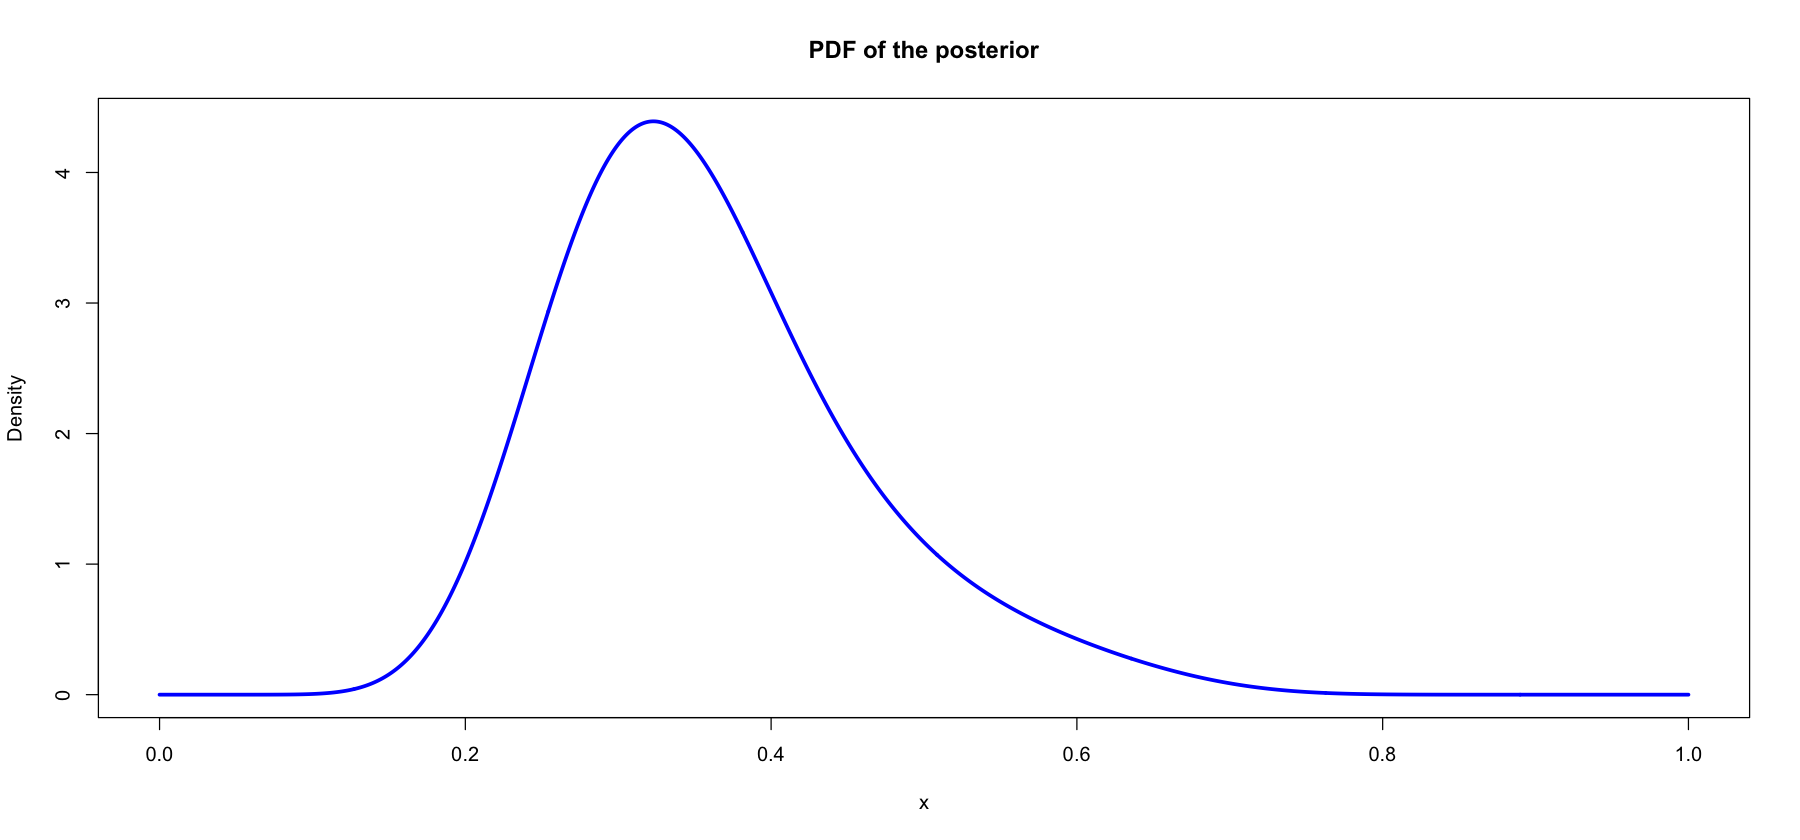

In [25]:
# Define the parameters for the posterior distribution
a_post <- c(10+x.obs, 15+x.obs, 20+x.obs)
b_post <- c(20+n-x.obs, 15+n-x.obs, 10+n-x.obs)

# Re-define the weights by computing the marginals for the given observations
f1<-choose(n,x.obs)*beta(a_post[1],b_post[1])/beta(a_prior[1],b_prior[1])
f2<-choose(n,x.obs)*beta(a_post[2],b_post[2])/beta(a_prior[2],b_prior[2])
f3<-choose(n,x.obs)*beta(a_post[3],b_post[3])/beta(a_prior[3],b_prior[3])
w_post <- c(w_prior[1]*f1, w_prior[2]*f2, w_prior[3]*f3)
suma <-sum(w_post)
w_post<- w_post / suma
# Define the range of x values to plot
x <- seq(0, 1, length.out = 1000)

# Compute the PDF of the mixture distribution
pdf_post <- w_post[1] * dbeta(x, a_post[1], b_post[1]) +
             w_post[2] * dbeta(x, a_post[2], b_post[2]) +
             w_post[3] * dbeta(x, a_post[3], b_post[3])

# Plot the PDF 
plot(x, pdf_post, type = "l", lwd = 3, col = "blue",
     main = "PDF of the posterior",
     xlab = "x", ylab = "Density")


#### Theoretical analysis of posterior formulas
Let us analysize the maximum a posteriori estimation (MAP), the posterior expectation and the posterior variance to make a comparison between analysis Bayesian study we are going to do.

#### MAP estimator
MAP estimate is an estimate of an unknown quantity, that equals the mode of the posterior distribution. Notice that

$$ \hat{\theta}_{MAP}(x) = \text{argmax}_{\theta}P(\theta|x),$$

where $P(\theta|x)$ is the posterior distribution. Let us code it and find the value!

In [26]:
# Find the maximum of the posterior pdf
x <- seq(0, 1, length.out = 1000)
theor_MAP <- x[which.max(pdf_post)]# find the argmax
theor_MAP<-round(theor_MAP,3)# round the value
print(paste("Theoretical MAP", theor_MAP))

[1] "Theoretical MAP 0.323"


#### Posterior Expectation

We know that our posterior distribution is a weighted sum of Beta's. More precisely,

$$X\sim \omega_1 Beta(\alpha_1,\beta_1)+\omega_2 Beta(\alpha_2,\beta_2)+\omega_3 Beta(\alpha_3,\beta_3) := \omega_1 X_1+\omega_2 X_2+\omega_3 X_3.$$

Since the integral of a sum is the sum of integrals, it is not difficult to see that 

$$\mathbb{E}(X) = \omega_1 \mathbb{E}[Beta(\alpha_1,\beta_1)]+\omega_2 \mathbb{E}[Beta(\alpha_2,\beta_2)]+\omega_3 \mathbb{E}[Beta(\alpha_3,\beta_3)]. $$

Moreover, it is well-known that 

$$\mathbb{E}[Beta(\alpha,\beta)]=\frac{\alpha}{\alpha+\beta}.$$

Let us code it and find the value!

In [27]:
# Find the expected value

theor_exp1<-(a_post[1])/(a_post[1]+b_post[1])# find the expectation for the first beta
theor_exp2<-(a_post[2])/(a_post[2]+b_post[2])# find the expectation for the second beta
theor_exp3<-(a_post[3])/(a_post[3]+b_post[3])# find the expectation for the third beta

theor_exp<-w_post[1]*theor_exp1+w_post[2]*theor_exp2+w_post[3]*theor_exp3 # total expectation
theor_exp<-round(theor_exp,3)# round the value

print(paste("Theoretical posterior expectation", theor_exp))

[1] "Theoretical posterior expectation 0.36"


#### Posterior Variance

As before, let us try to figure out which is the variance of $X$. This, is not as simple as the expectation, let us compute it step by step. Assuming previous notation, we have that

$$Var[X] = \int (\theta - \mathbb{E}[X])^2\sum_{i=1}^{3}\omega_i Beta(\alpha_i,\beta_i)d\theta = \int\sum_{i=1}^{3}\left((\theta -\mathbb{E}[X_i]+\mathbb{E}[X_i]+ \mathbb{E}[X])\right)^2\omega_i Beta(\alpha_i,\beta_i)d\theta=\sum_{i=1}^{3}\omega_i\int\left(\theta- \mathbb{E}[X_i]\right)^2 Beta(\alpha_i,\beta_i)d\theta + \sum_{i=1}^{3}\omega_i\left(\mathbb{E}[X_i]-\mathbb{E}[X]\right)^2\int Beta(\alpha_i,\beta_i)d\theta + 2\sum_{i=1}^{3}\omega_i\left(\mathbb{E}[X_i]-\mathbb{E}[X]\right)\int\left(\theta- \mathbb{E}[X_i]\right)Beta(\alpha_i,\beta_i)d\theta=\sum_{i=1}^{3}\omega_i Var(B(\alpha_i,\beta_i)) + \sum_{i=1}^{3}\omega_i\left(\mathbb{E}[X_i]-\mathbb{E}[X]\right)^2+ 2\sum_{i=1}^{3}\omega_i\left(\mathbb{E}[X_i]-\mathbb{E}[X]\right)\left(\mathbb{E}[Beta(\alpha_i,\beta_i)]-\mathbb{E}[X_i]\right)=\sum_{i=1}^{3}\omega_i Var[Beta(\alpha_i,\beta_i)] + \sum_{i=1}^{3}\omega_i\left(\mathbb{E}[X_i]-\mathbb{E}[X]\right)^2.$$

Moreover, it is well-known that

$$Var[Beta(\alpha_i,\beta_i)] = \frac{\alpha\beta}{(\alpha+\beta)^2(\alpha+\beta+1)}.$$

Let us code it and find the value!

In [28]:
# Find the variance

theor_var1<-(a_post[1]*b_post[1])/((a_post[1]+b_post[1])^2*(a_post[1]+b_post[1]+1))# find the var for the first beta
theor_var2<-(a_post[2]*b_post[2])/((a_post[2]+b_post[2])^2*(a_post[2]+b_post[2]+1))# find the var for the seond beta
theor_var3<-(a_post[3]*b_post[3])/((a_post[3]+b_post[3])^2*(a_post[3]+b_post[3]+1))# find the var for the third beta

theor_var<-w_post[1]*theor_var1+w_post[2]*theor_var2+w_post[3]*theor_var3+
            w_post[1]*(theor_exp1-theor_exp)^2+
            w_post[2]*(theor_exp2-theor_exp)^2+
            w_post[3]*(theor_exp3-theor_exp)^2 # total variance 

theor_var<-round(theor_var,3)# round the value
print(paste("Theoretical posterior variance", theor_var))

[1] "Theoretical posterior variance 0.01"


###  2.Bayesian Analysis using independent random numbers

Let us repeat the Bayesian model but using independent random numbers. Let us define the variables of our problem.

In [1]:
# Sample size
N<-30000 
# Number of trials
n_trials<-10
# Observed x
x.obs<-3

To obtain samples from the prior distribution, a procedure is required. The prior distribution is composed of a mixture of Beta functions, and in order to simulate the process, we will randomly assign each coin to one of the three Beta functions. Once the assignment is made, we can calculate the corresponding theta value for each coin using the `rbeta` function. Moreover, we will compare the simulated prior with the theoretical one obtained in the previous exercise.

ERROR: Error in plot.default(0, 0, type = "n", xlim = c(0, 1), ylim = c(0, max(pdf_prior) * : objeto 'pdf_prior' no encontrado


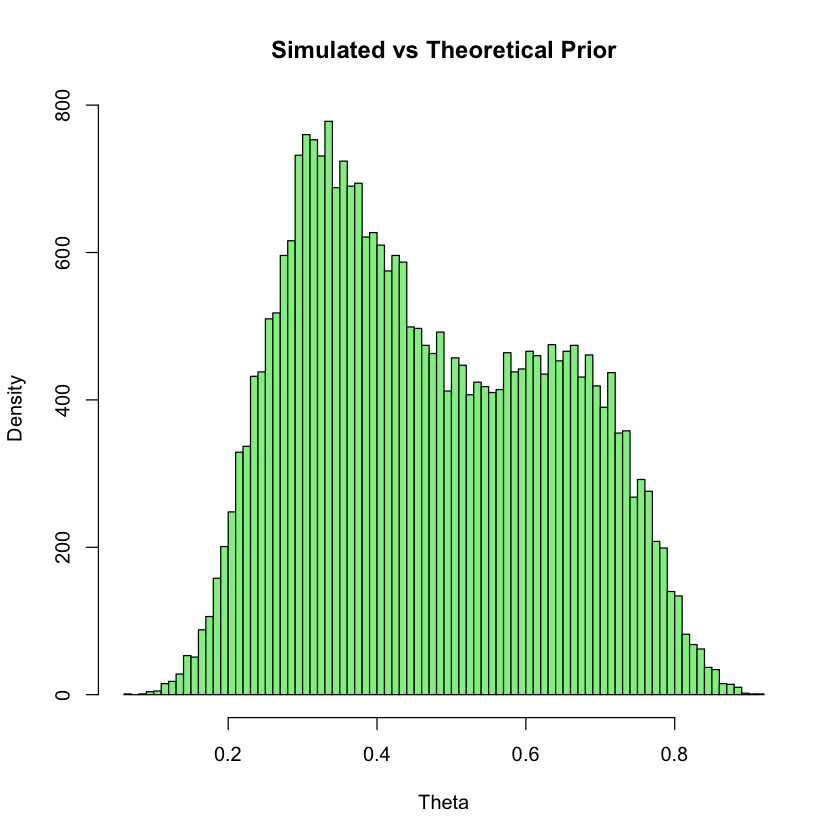

In [2]:
# Randomly assignation
random_assign <- sample(c(1,2,3), replace = TRUE, size = N, prob=c(0.5, 0.2, 0.3))

# Generate thetas 
thetas <- c(rbeta(N,10,20)[random_assign == 1], 
            rbeta(N,15,15)[random_assign == 2], 
            rbeta(N,20,10)[random_assign == 3])

# Simulated prior vs theoretical prior

# Plot the simulated prior
hist(thetas, breaks=100, main="Simulated vs Theoretical Prior", xlab="Theta", ylab="Density",col='Lightgreen')

# Add a secondary axis for the theoretical prior
par(new=TRUE)
plot(0, 0, type="n", xlim=c(0,1), ylim=c(0, max(pdf_prior)*1.1), xaxt="n", yaxt="n", xlab="", ylab="")
axis(side=4)
mtext("Theoretical Prior", side=4, line=3)

# Add the theoretical prior to the plot
u<-seq(0,1,length=1000)
lines(u,pdf_prior,lwd=2.5,col="Darkgreen")


Our next step involves calculating the prior predictive pmf by generating samples from a Binomial distribution, where we will use the previous thetas as probabilities. We will then analyze the frequency of the obtained number of heads and display the resulting prior predictive pmf of our simulation.

Absolute frequency:



| m  | freq |
|:--:|:----:|
| 0  | 482  |
| 1  | 1735 |
| 2  | 3273 |
| 3  | 4296 |
| 4  | 4785 |
| 5  | 4461 |
| 6  | 3949 |
| 7  | 3333 |
| 8  | 2243 |
| 9  | 1143 |
| 10 | 300  |


Relative frequency:



| heads |   Freq    |
|:-----:|:---------:|
|   0   | 0.0160667 |
|   1   | 0.0578333 |
|   2   | 0.1091000 |
|   3   | 0.1432000 |
|   4   | 0.1595000 |
|   5   | 0.1487000 |
|   6   | 0.1316333 |
|   7   | 0.1111000 |
|   8   | 0.0747667 |
|   9   | 0.0381000 |
|  10   | 0.0100000 |

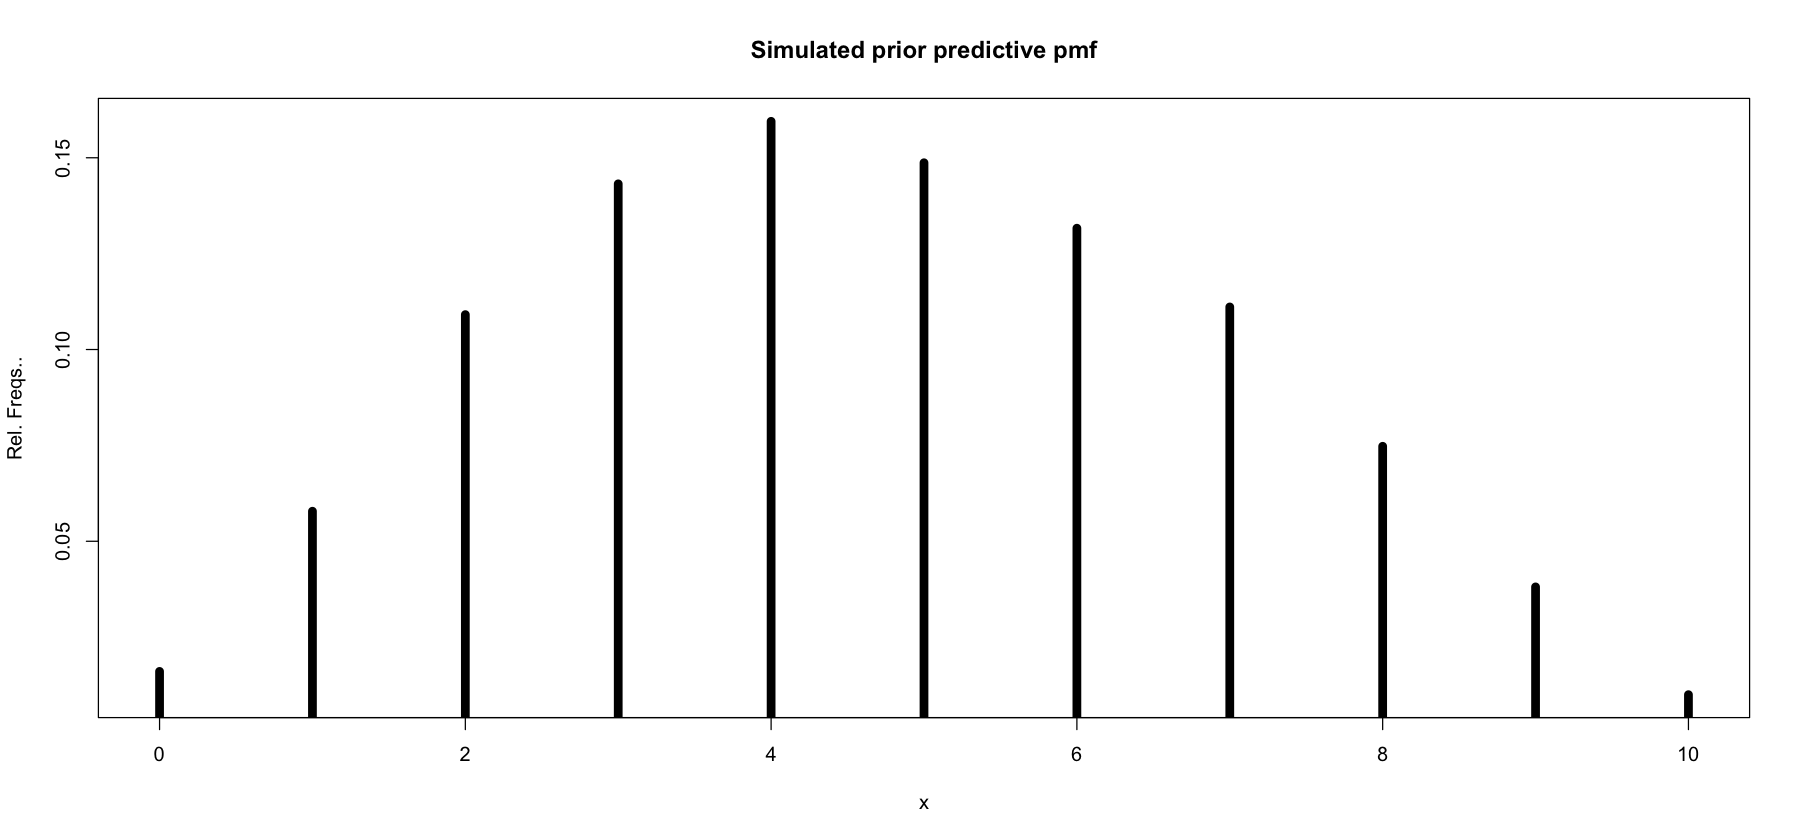

In [41]:
# Generate values from a Binomial
heads <- rbinom(n = N, size = n_trials, prob = thetas)

# Absolute frequencies
cat("Absolute frequency:")
abs_freq <- as.data.frame(table(heads))
names(abs_freq) <- c("m", "freq")
knitr::kable(abs_freq, align = "c")

# Relative frequencies
cat("\nRelative frequency:")
r<-table(heads)/sum(table(heads))
rel_freq <- as.data.frame(r)
knitr::kable(rel_freq, align = "c")
 
# Plot relative frequencies
matplot(x=names(r),y=r ,type="h",lwd=7, lty=1,
        xlab="x",ylab="Rel. Freqs..",
        main="Simulated prior predictive pmf")


Now, let us study the posterior probability of having 3 of our observations (heads), given theta. Moreover, we will compare it with the theoretical one obtained in the previous exercise.

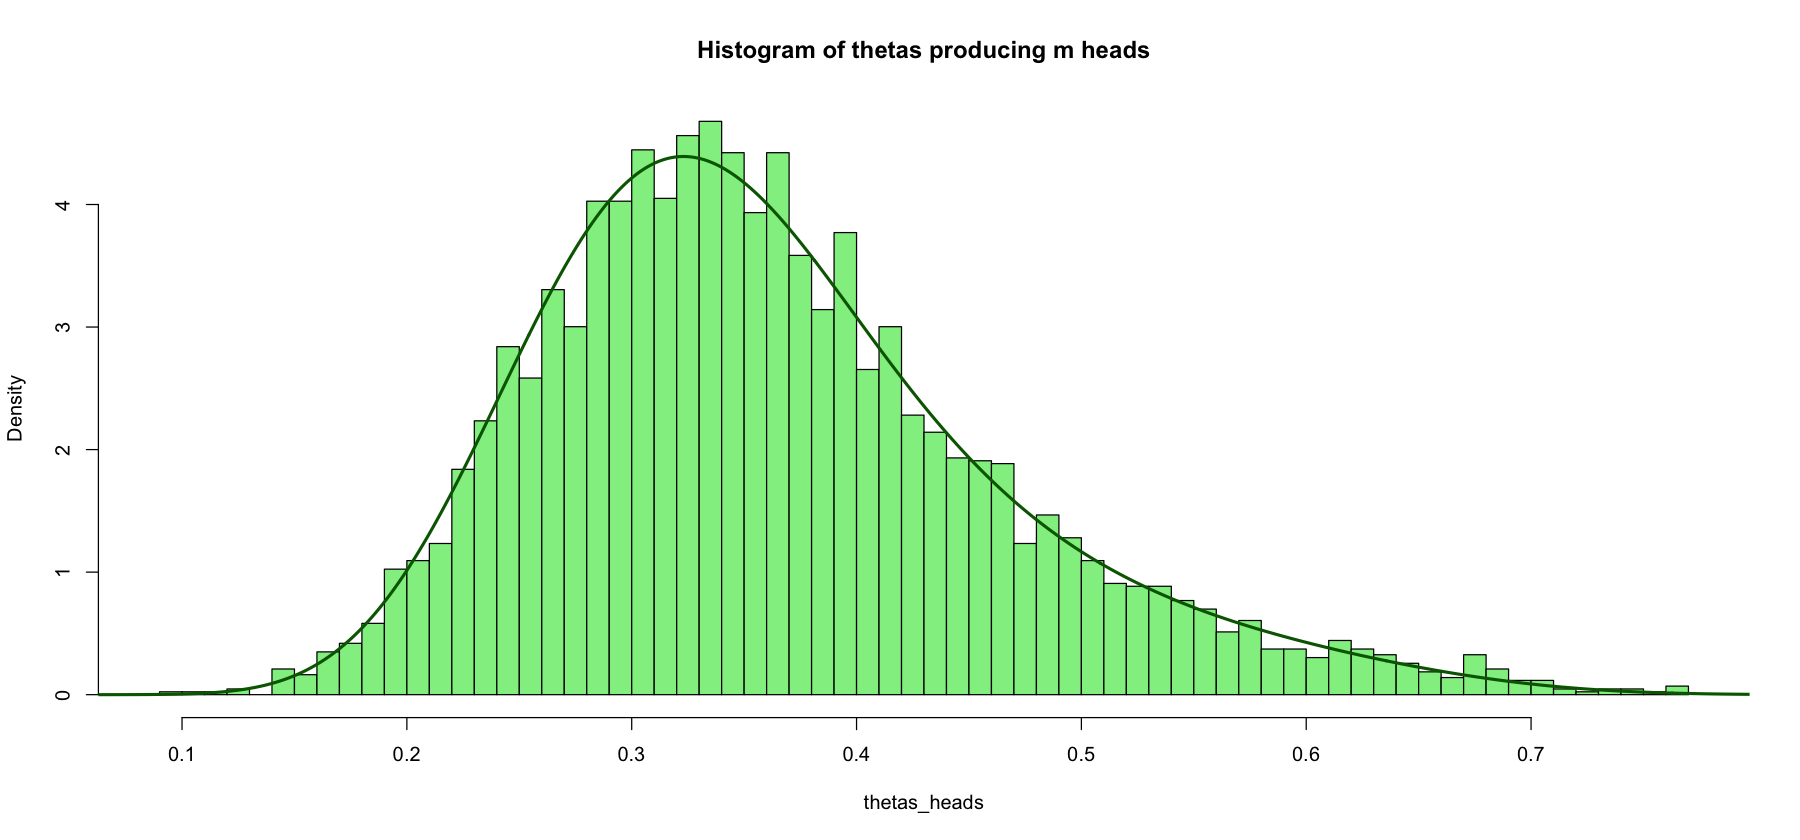

In [42]:
# Cases in which we get 3 heads
heads_idx <- which(heads == x.obs)

# Genereated thetas with 3 heads
thetas_heads <- thetas[heads_idx]

# Simulated posterior vs theoretical
hist(thetas_heads, breaks=50, freq=FALSE, main = "Histogram of thetas producing 3 heads",col='Lightgreen')
u<-seq(0,1,length=1000)
lines(u,pdf_post,lwd=2.5,col="Darkgreen")

#### Analysis of posterior formulas
Let us analysize the maximum a posteriori estimation (MAP), the posterior expectation and the posterior variance to make a comparison between analysis Bayesian study we are going to do.

#### MAP estimator

In [46]:
# Find the maximum of the posterior pdf
thetas_heads_density <-density(thetas_heads)
MAP<-thetas_heads_density$x[which.max(thetas_heads_density$y)]# find the argmax
sim_MAP2<-round(MAP,3)# round the value
print(paste("Simulated MAP",sim_MAP2))

[1] "Simulated MAP 0.334"


#### Posterior Expectation

In [47]:
# Simulated Expectation
exp<-mean(thetas_heads)
sim_exp2<-round(exp,3)# round the value
print(paste("Simulated posterior expectation", sim_exp2))

[1] "Simulated posterior expectation 0.362"


#### Posterior  Variance

In [48]:
# Simulated Variance
var<-var(thetas_heads)
sim_var2<-round(var,3)# round the value
print(paste("Simulated posterior expectation", sim_var2))

[1] "Simulated posterior expectation 0.011"


### 3.Bayesian analysis using JAGS

Let us repeat the Bayesian analysis using JAGS. First, let us install the packages.

In [49]:
#install.packages("R2jags",dependencies=TRUE,repos= "https://cloud.r-project.org")
require(R2jags)

Loading required package: R2jags

Loading required package: rjags

Loading required package: coda


Attaching package: ‘coda’


The following object is masked from ‘package:rstan’:

    traceplot


Linked to JAGS 4.3.1

Loaded modules: basemod,bugs


Attaching package: ‘R2jags’


The following object is masked from ‘package:coda’:

    traceplot


The following object is masked from ‘package:rstan’:

    traceplot




Let us create a list of our prior variables to use our JAGS model.

In [50]:
# Data 
Mix.01.dat<-list(a1=a_prior[1],b1=b_prior[1],a2=a_prior[2],b2=b_prior[2],a3=a_prior[3],b3=b_prior[3]
                 ,w1=w_prior[1],w2=w_prior[2],w3=w_prior[3],n=n,x=x.obs)

In [51]:
# JAGS model
cat(
"model
    {
    x~dbin(p,n)             # Binomial likelihood. See arguments order!
    
    p<-theta[r]             # Prior is a mixture of three beta r.v 
                            # Notice the syntax: this statement says that p is
                            # *equal to* the pair of theta variates defined below

    r~dcat(g[])             # Categorical distribution:
                            # g[] is a 3-vector containing the mixing probabilities (w1, w2,w3)

    theta[1]~dbeta(a1,b1)   # The three beta r.v to enter the mixture
    theta[2]~dbeta(a2,b2)
    theta[3]~dbeta(a3,b3)

    g[1]<-w1            # Just as in p. g is equal to (w1, w2,w3)
    g[2]<-w2
    g[3]<-w3
    }"
    ,file="Mix.01.jag")

Let us run JAGS with 3 chains, 5000 iterations and 500 discards.

In [52]:
Mix.01.m1<-jags(data=Mix.01.dat, n.chains=3,n.iter=5000,n.burnin=500, 
        parameters.to.save=c("theta","p"), model.file="Mix.01.jag")

module glm loaded



Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1
   Unobserved stochastic nodes: 4
   Total graph size: 17

Initializing model



In [53]:
# Detailed information
print(Mix.01.m1)

Inference for Bugs model at "Mix.01.jag", fit using jags,
 3 chains, each with 5000 iterations (first 500 discarded), n.thin = 4
 n.sims = 3375 iterations saved
         mu.vect sd.vect  2.5%   25%   50%   75% 97.5%  Rhat n.eff
p          0.361   0.102 0.197 0.291 0.348 0.419 0.601 1.001  2900
theta[1]   0.327   0.076 0.188 0.273 0.324 0.376 0.481 1.001  3400
theta[2]   0.494   0.088 0.325 0.431 0.494 0.556 0.657 1.001  3400
theta[3]   0.662   0.085 0.487 0.604 0.665 0.725 0.817 1.001  3400
deviance   3.243   1.024 2.643 2.685 2.841 3.331 6.337 1.002  1500

For each parameter, n.eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor (at convergence, Rhat=1).

DIC info (using the rule, pD = var(deviance)/2)
pD = 0.5 and DIC = 3.8
DIC is an estimate of expected predictive error (lower deviance is better).


#### Traceplots
A trace plot is a line plot that displays the posterior samples of a parameter or set of parameters in a Markov chain Monte Carlo (MCMC) simulation. The trace plot can be used to visually inspect the convergence of the MCMC algorithm, that is, whether the algorithm has reached a stable distribution, and to diagnose potential issues such as autocorrelation or lack of convergence. The ideal trace plot shows a stable, random walk with no obvious trends or patterns. Let us observe our traceplots!

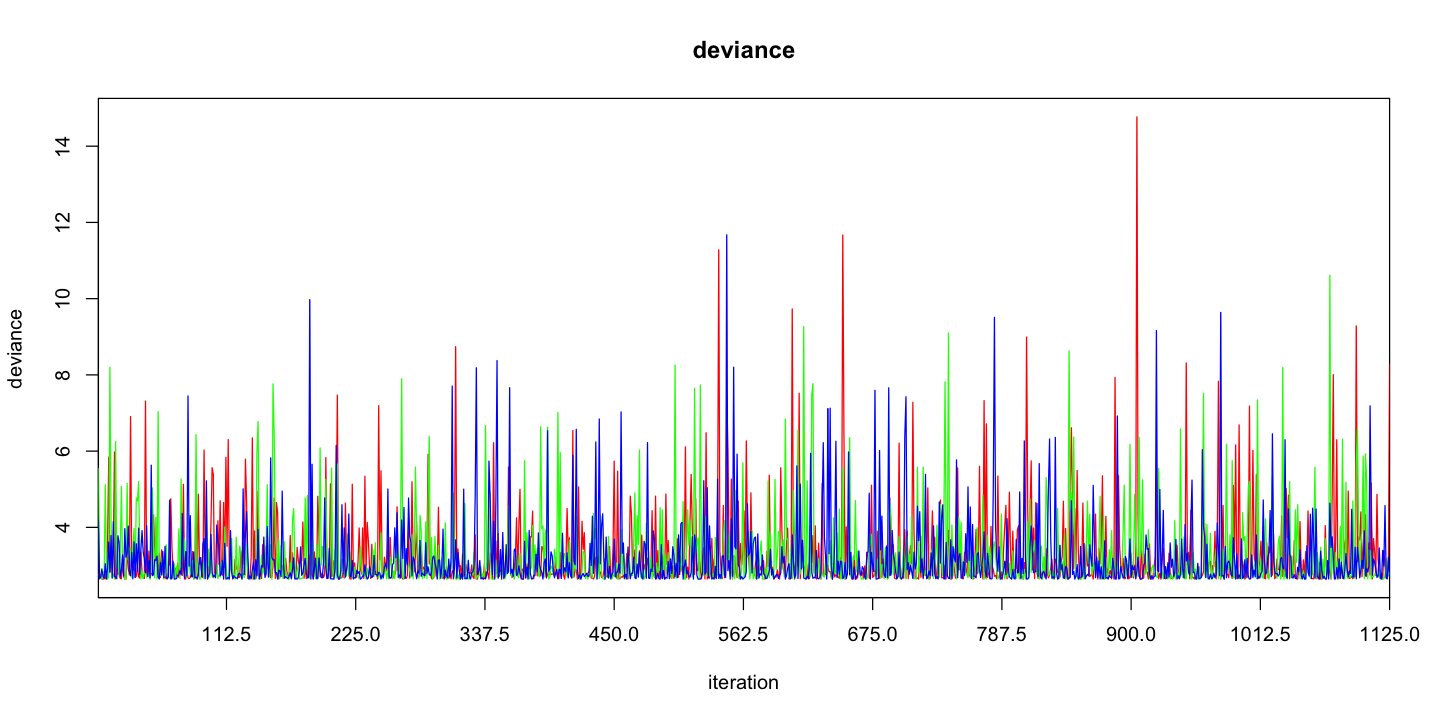

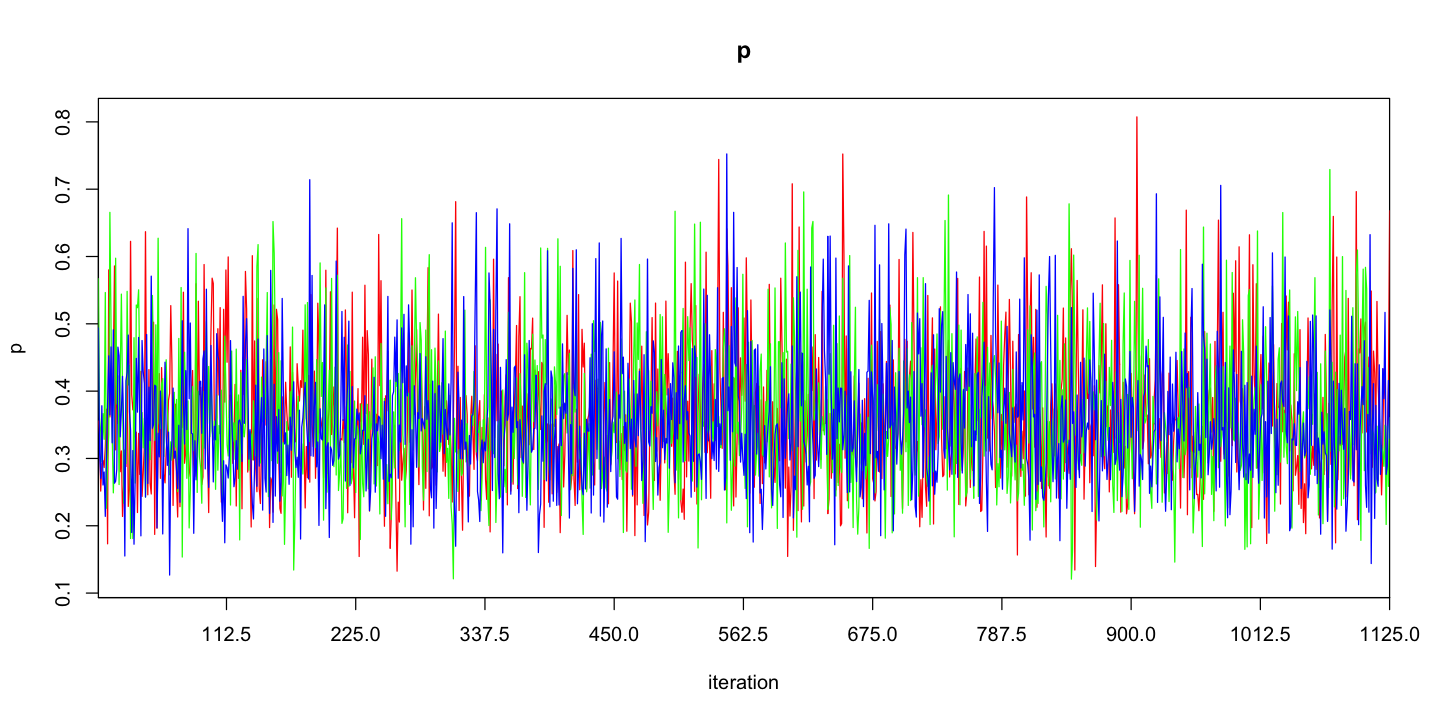

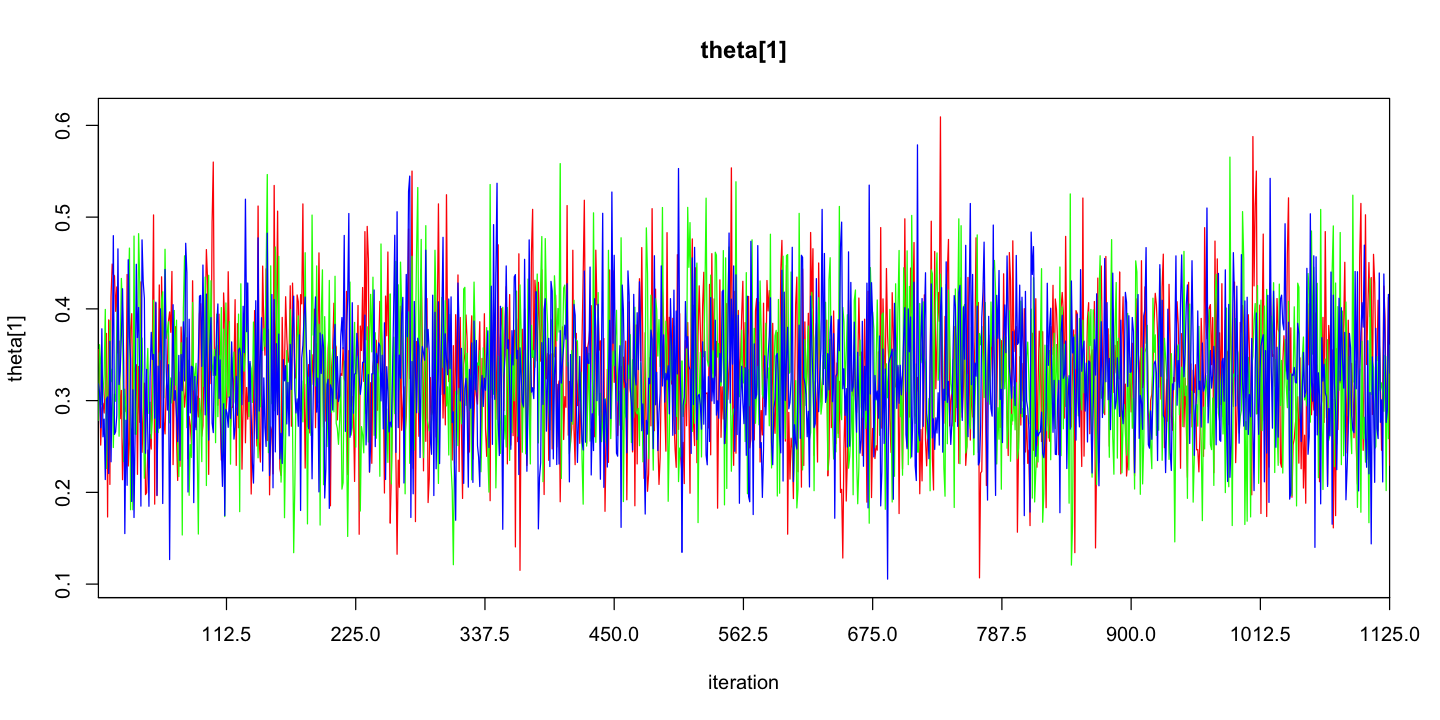

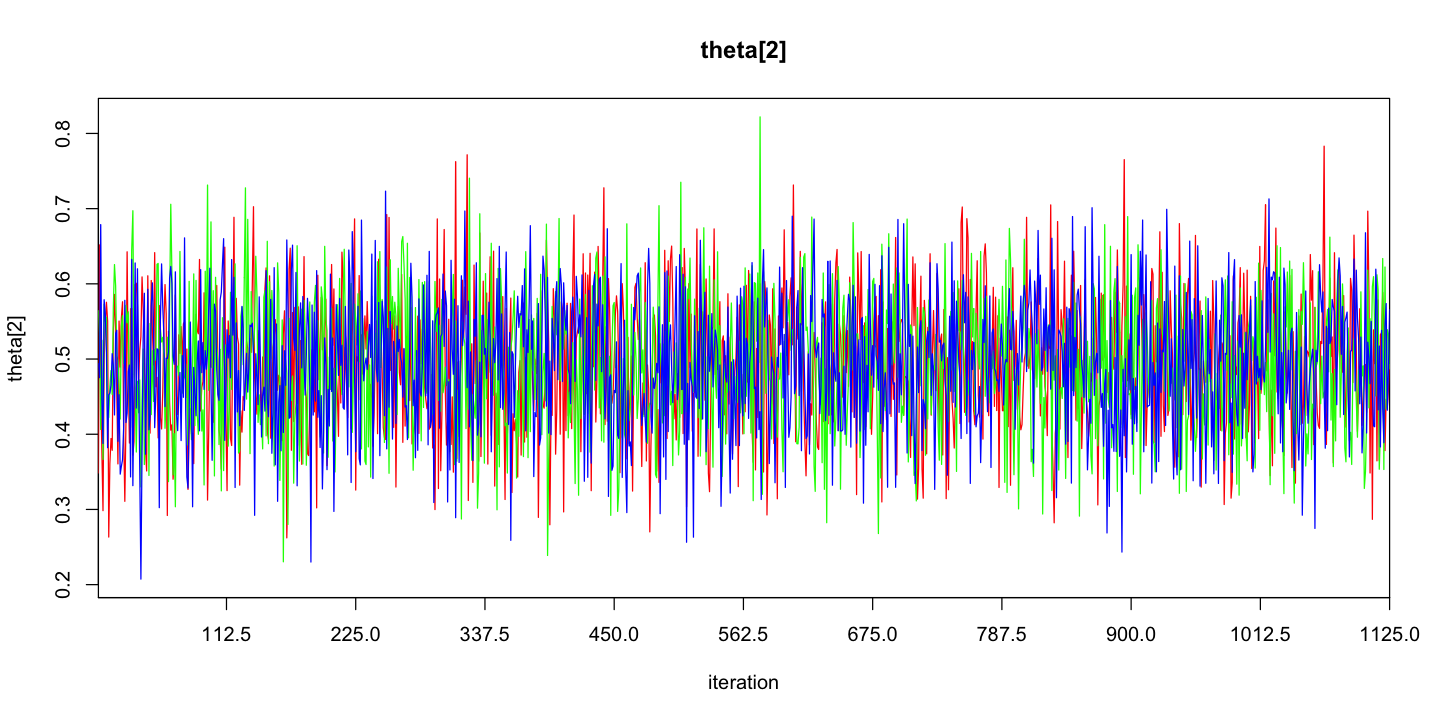

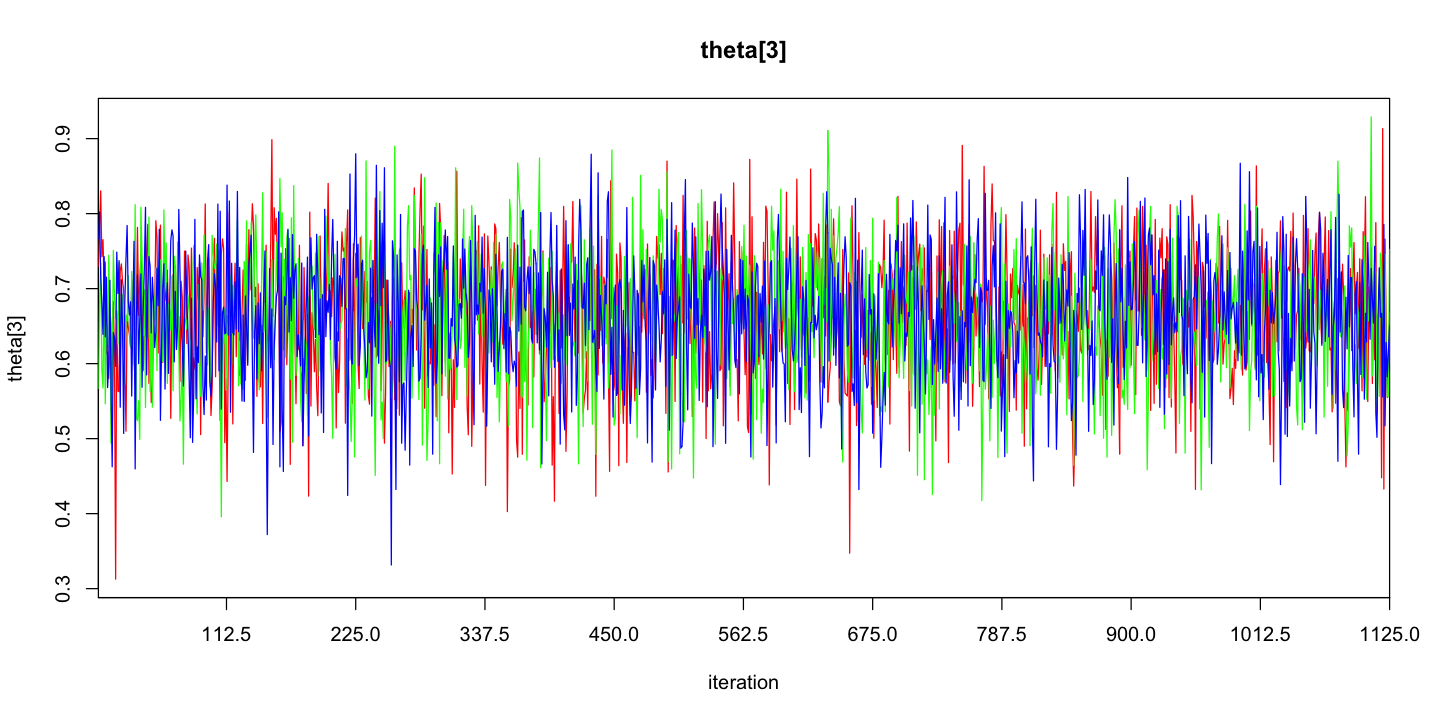

In [54]:
options(repr.plot.width=12,repr.plot.height=6)
traceplot(Mix.01.m1)

Finally, let us plot the simulated posterior pdf and compare it with the theoretical one.

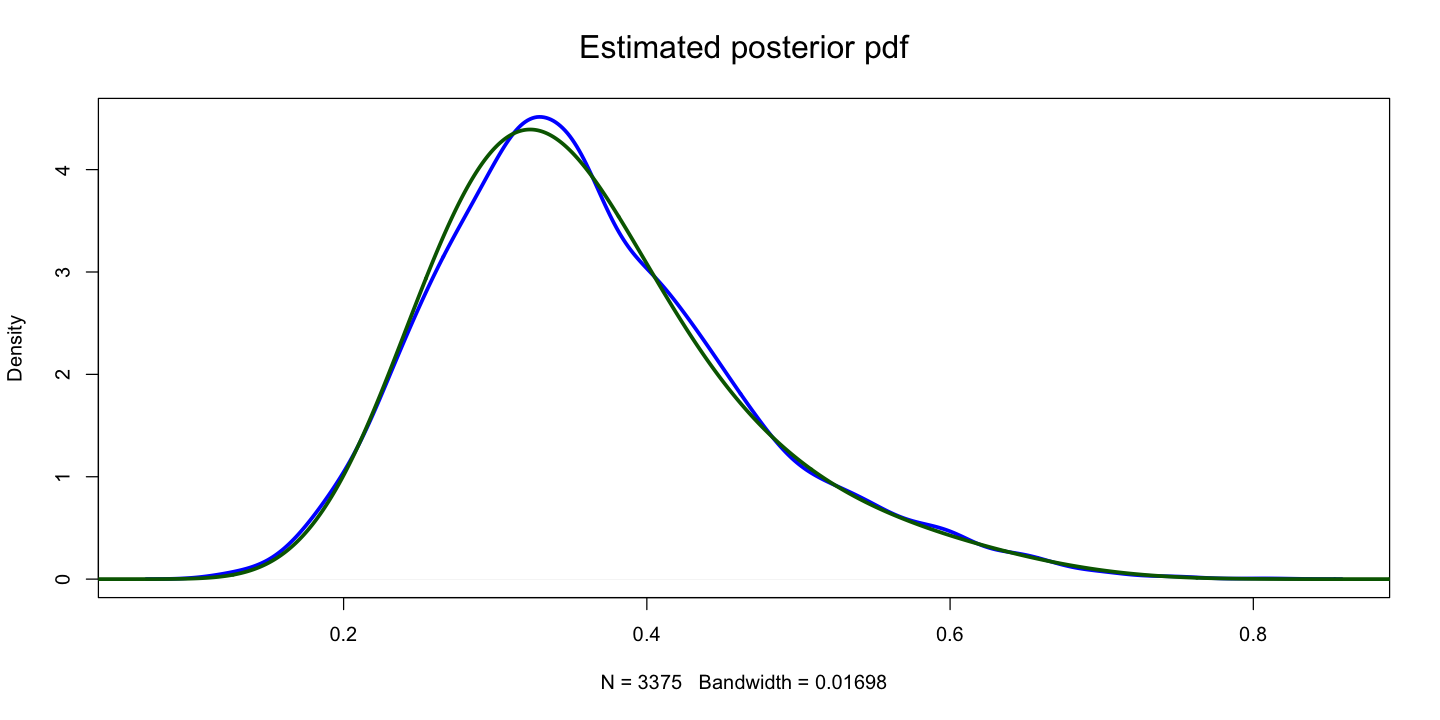

In [57]:
# Simulated posterior in blue
p.sample<-Mix.01.m1$BUGSoutput$sims.list$p
p.sample.density<-density(p.sample)
plot(p.sample.density,lwd=3,col="blue",main=expression(paste("Estimated posterior pdf")),cex.main=1.6)
# Theoretical in green
u<-seq(0,1,length=1000)
lines(u,pdf_post,lwd=3,col="Darkgreen")

#### Analysis of posterior formulas

Let us analysize the maximum a posteriori estimation (MAP), the posterior expectation and the posterior variance to make a comparison between analysis Bayesian study we are going to do.

#### MAP estimator

In [58]:
# Find the maximum of the posterior pdf
thetas_heads_density <-density(p.sample)
MAP<-thetas_heads_density$x[which.max(thetas_heads_density$y)]# find the argmax
sim_MAP3<-round(MAP,3)# round the value
print(paste("Simulated MAP",sim_MAP3))

[1] "Simulated MAP 0.329"


#### Posterior Expectation

In [59]:
# Simulated Expectation
exp<-mean(p.sample)
sim_exp3<-round(exp,3)# round the value
print(paste("Simulated posterior expectation", sim_exp3))

[1] "Simulated posterior expectation 0.361"


#### Posterior  Variance

In [60]:
# Simulated Variance
var<-var(p.sample)
sim_var3<-round(var,3)# round the value
print(paste("Simulated posterior expectation", sim_var3))

[1] "Simulated posterior expectation 0.01"


### 4. Bayesian analysis using Stan

Let us repeat the Bayesian analysis using Stan. First, let us install the packages.

In [61]:
#install.packages("rstan", dependencies=TRUE,repos= "https://cloud.r-project.org")
require(rstan)

In [62]:
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

Let us build and compile our model. We have adapted the code given in `Mixture.priors.01.Stan.ipynb`, performing an extension of the two-component to tree. The only difficult new line in the code is: 
> p =theta[u<w1? 1: (u<w2 ? 2 : 3)] ;

In [63]:
modelString = "
    data{
        int<lower=0> n ;
        int<lower=0> x ; 
        real<lower=0> a1 ;
        real<lower=0> b1 ;
        real<lower=0> a2 ;
        real<lower=0> b2 ;
        real<lower=0> a3 ;
        real<lower=0> b3 ;
        real<lower=0,upper=1>  w1 ;
        real<lower=0,upper=1>  w2 ;
        real<lower=0,upper=1>  w3 ;
    }
    parameters{
        real<lower=0,upper=1>  u ;
        vector<lower=0,upper=1>[3] theta ;
    }
    transformed parameters{                         
        real<lower=0,upper=1> p ;                   
        // Generate on the spot the unnamed index selecting 
        // which of the components in the mixture is chosen
        // adaptation to three betas instead of two
        p =theta[u<w1? 1: (u<w2 ? 2 : 3)] ;
    }
    model{
        x ~ binomial(n,p) ;
        theta[1] ~ beta(a1,b1) ;
        theta[2] ~ beta(a2,b2) ;
        theta[3] ~ beta(a3,b3) ;
        u ~ uniform(0,1) ; 
    }"

In [64]:
# Translate model to C++ and compile to DSO:
stanDso <- stan_model( model_code=modelString ) 

Now, we create a list of the inputs parameters and perform the sampling.

In [65]:
Mix.01.dat<-list(a1=a_prior[1],b1=b_prior[1],a2=a_prior[2],b2=b_prior[2],a3=a_prior[3],b3=b_prior[3]
                 ,w1=w_prior[1],w2=w_prior[2],w3=w_prior[3],n=n,x=x.obs)

In [66]:
# Generate posterior sample:
stanFit <- sampling( object=stanDso, 
                     data = Mix.01.dat, 
                     chains = 3,
                     iter = 5000, 
                     warmup = 100, 
                     thin = 1)

Finally, we can perform an analysis of the posterior pdf using the `bayesplot` package. Let us install it and work on it.

In [67]:
#install.packages("bayesplot", dependencies=TRUE,repos= "https://cloud.r-project.org")
require(bayesplot)

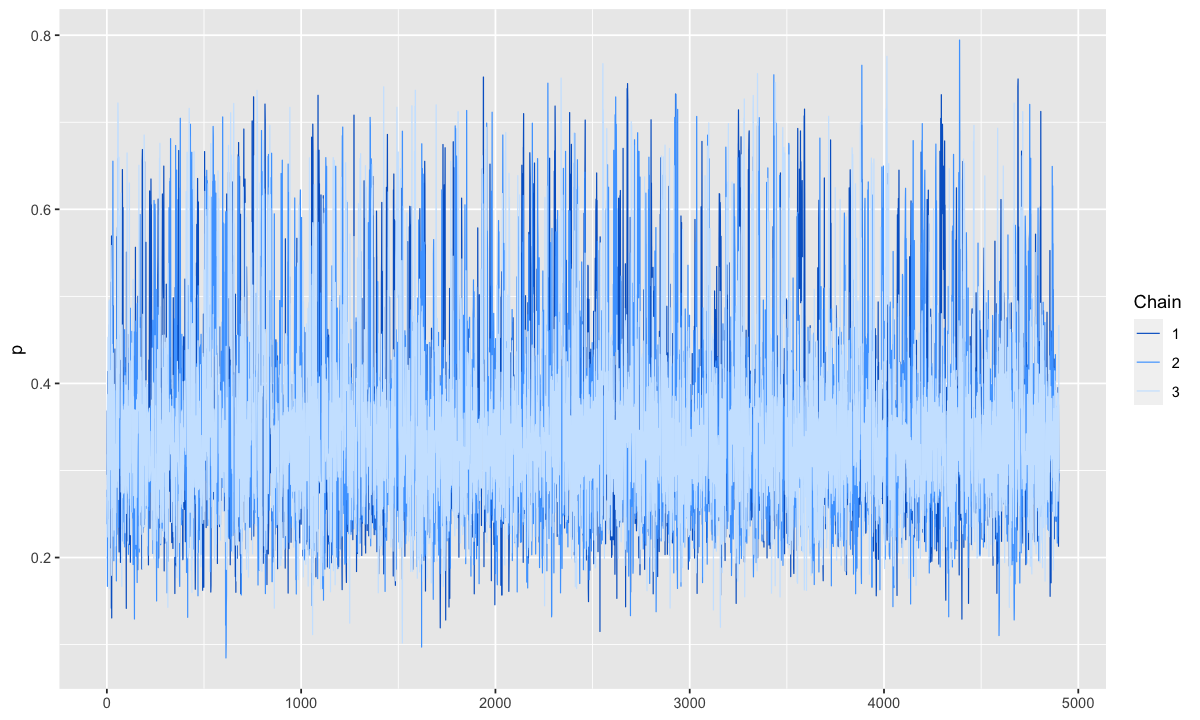

In [68]:
color_scheme_set("brightblue")
options(repr.plot.width=10,repr.plot.height=6)
mcmc_trace(stanFit, pars = c("p"))

#### Areas diagram

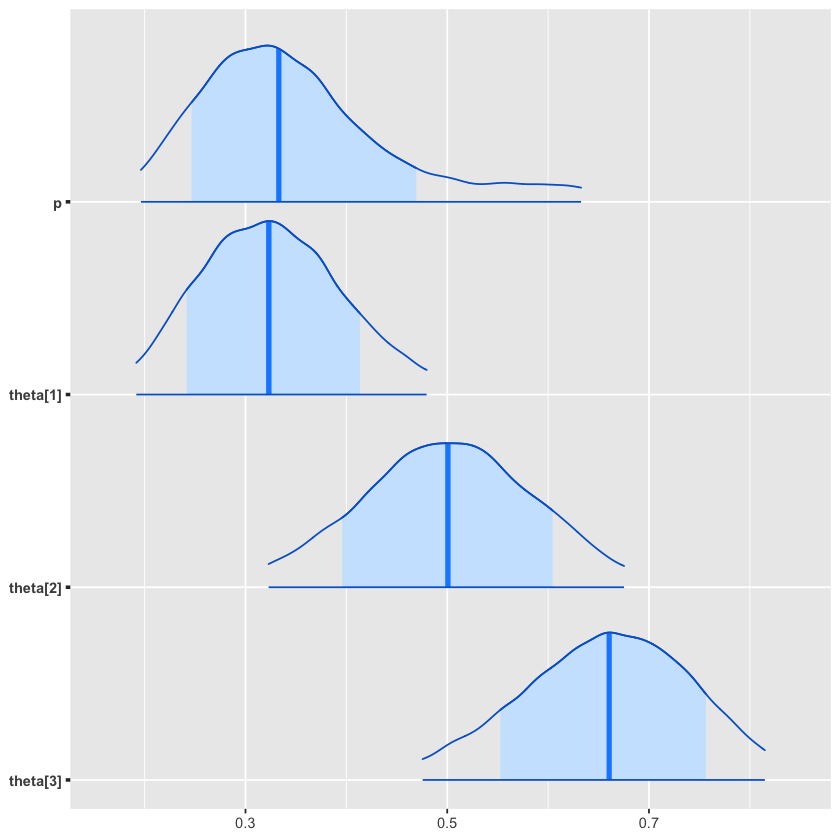

In [69]:
color_scheme_set("brightblue")
options(repr.plot.width=7,repr.plot.height=7)
mcmc_areas(stanFit, pars = c("p","theta[1]","theta[2]","theta[3]"),prob=0.75,prob_outer=0.95)

#### Histogram

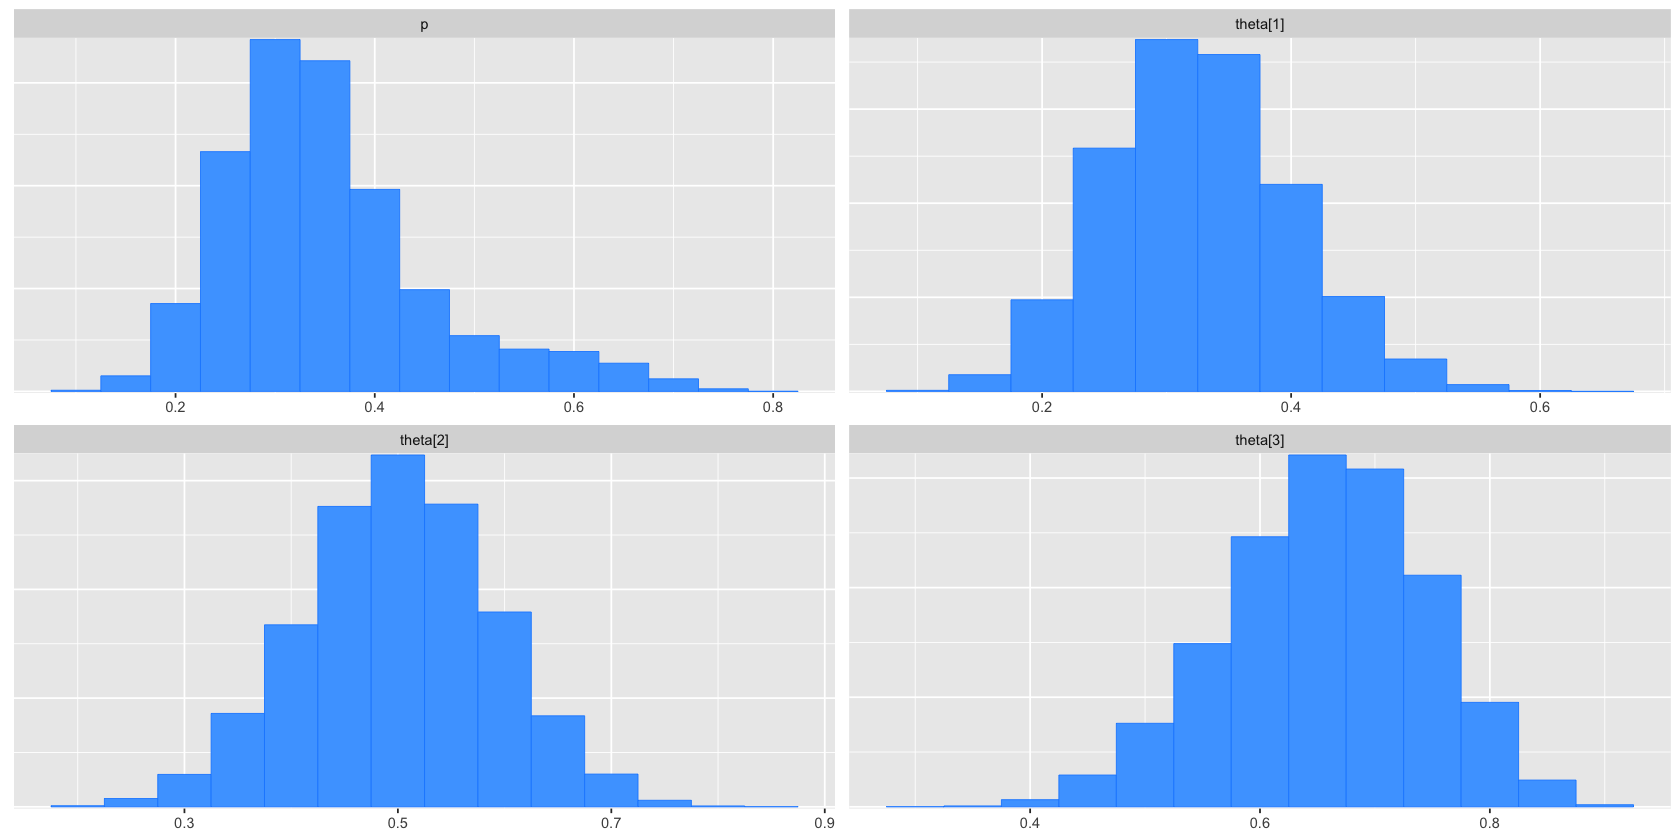

In [70]:
color_scheme_set("brightblue")
options(repr.plot.width=14,repr.plot.height=7)
mcmc_hist(stanFit, pars = c("p","theta[1]","theta[2]","theta[3]"),binwidth=0.05)

#### Density plot

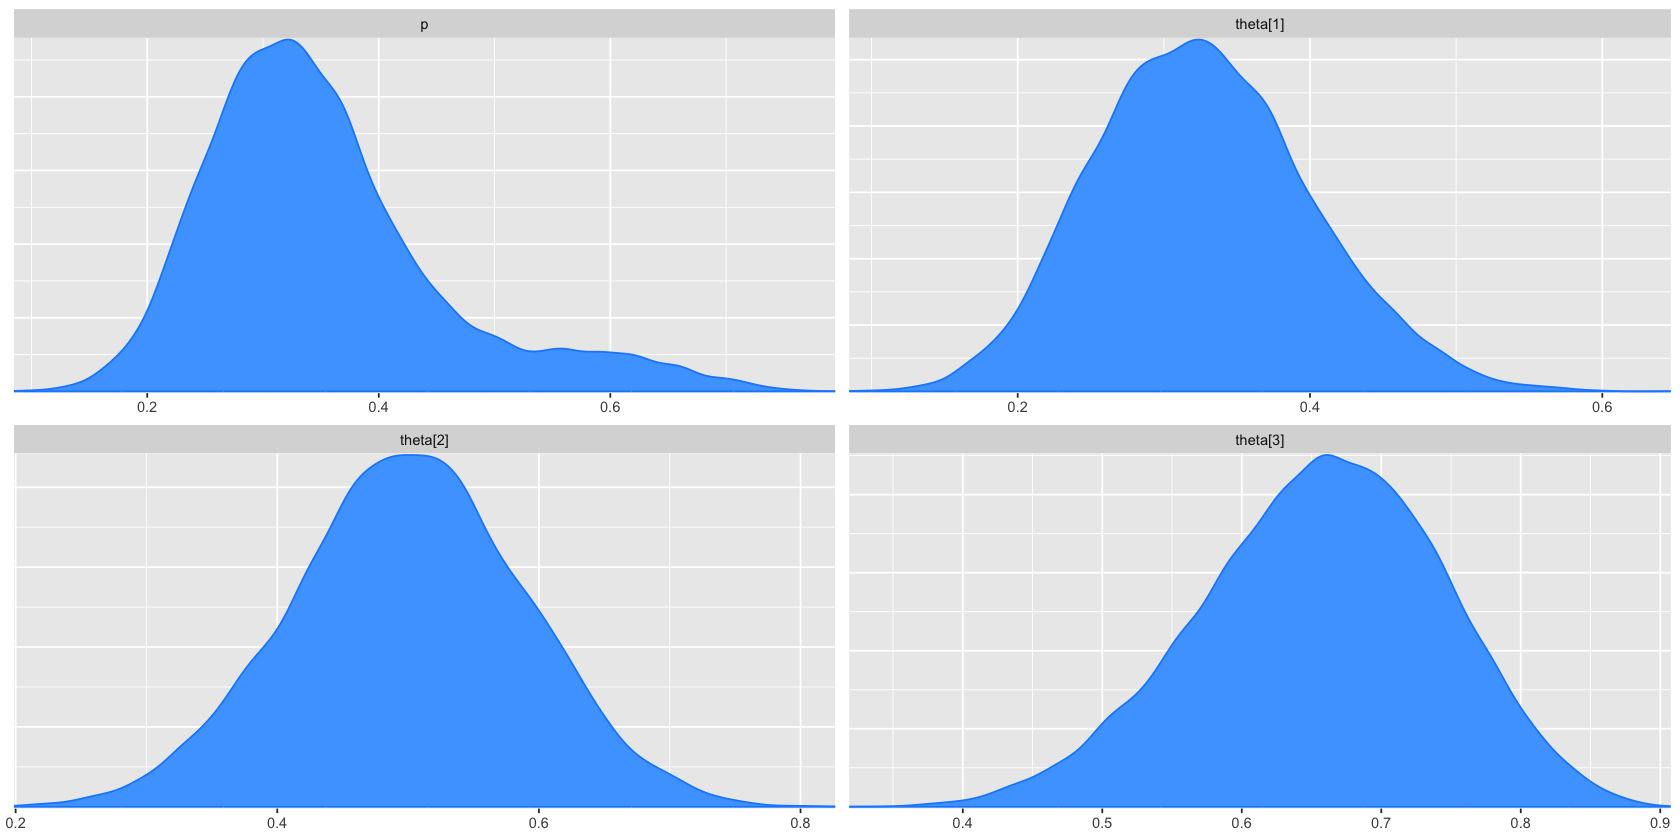

In [71]:
color_scheme_set("brightblue")
options(repr.plot.width=14,repr.plot.height=7)
mcmc_dens(stanFit, pars = c("p","theta[1]","theta[2]","theta[3]"))

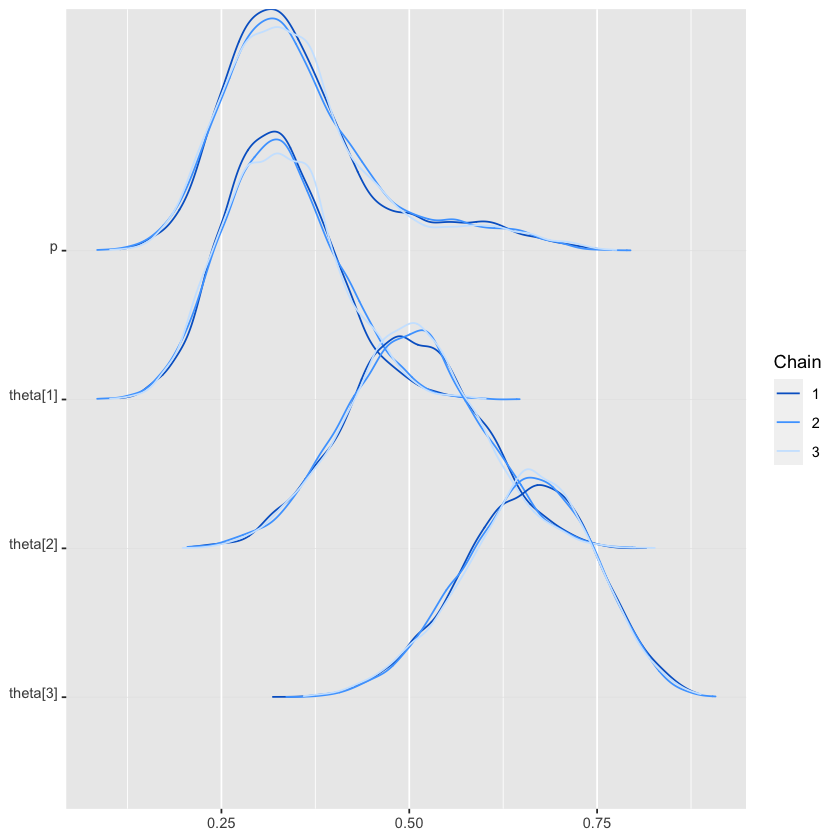

In [72]:
color_scheme_set("brightblue")
options(repr.plot.width=7,repr.plot.height=7)
mcmc_dens_chains(stanFit, pars = c("p","theta[1]","theta[2]","theta[3]"))

#### Violin plot

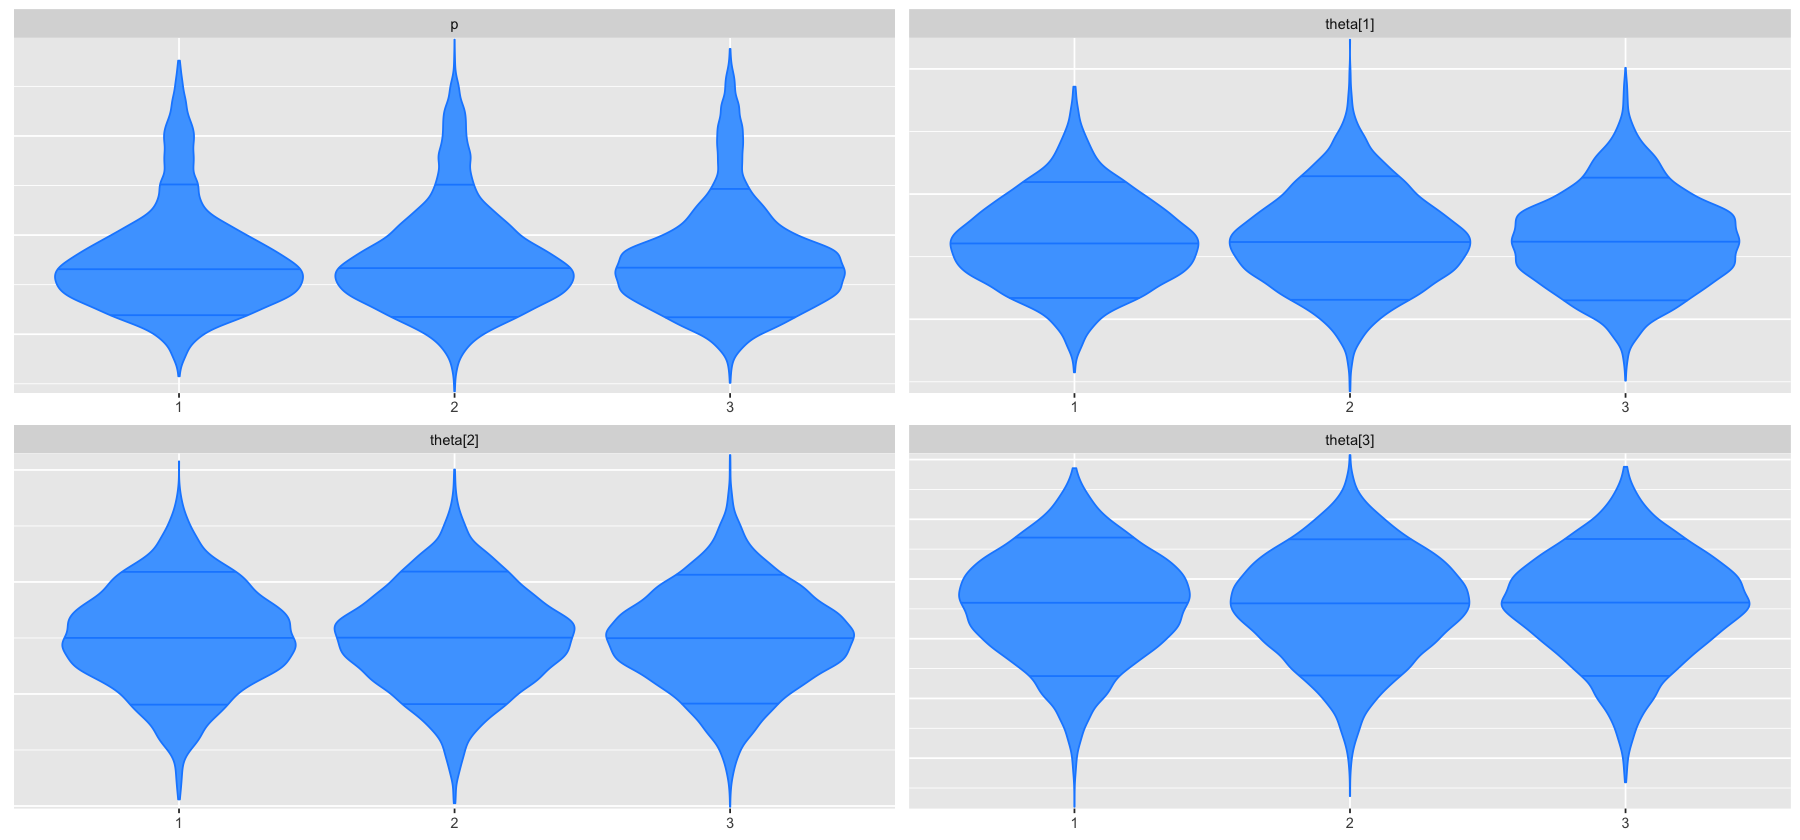

In [73]:
color_scheme_set("brightblue")
options(repr.plot.width=15,repr.plot.height=7)
mcmc_violin(stanFit, pars = c("p","theta[1]","theta[2]","theta[3]"))

### REFERENCES

For the deduction of the formulas provided in the theoretical study of the Bayesian model (EXERCISE 02), the following has been used
+ https://gregorygundersen.com/blog/2020/08/19/bernoulli-beta/
+ The notebook `Mixture.priors.01` given in Session07.

For general knowledge we have used the following book:

+ Bayesian methods for hackers: Probabilistic programming and Bayesian inference. Davidson-Pilon, C. (2015).

To solve the rest of the exercises, we have used the notebooks given to us in the theoretical sessions.